# Project Overview
For this project, I utilized the Home Mortgage Disclosure Act (HMDA) API, I aggregated data on mortgage loan applications in Miami-Dade County. Below, I've detailed my process of cleaning up and exploring the data, as well as creating multiple visualizing for unique trends over time (2007-2017). I also created a simple classification model (Random Forest) to predict whether an application would be approved or not, based on the features in the dataset.

I view this as very much a work in progress and will and more analysis and code comments overtime. I also plan to try other models and well as further tune my existing Random Forest Classifier.

## Data Import

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import StratifiedKFold
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.base import TransformerMixin, BaseEstimator
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import RandomForestClassifier

%matplotlib inline
%config InlineBackend.figure_format = 'retina'
plt.style.use('ggplot')

In [2]:
pd.set_option('display.max_columns', 100)

In [3]:
#HMDA API link for csv file download
df_original = pd.read_csv('https://api.consumerfinance.gov:443/data/hmda/slice/hmda_lar.csv?$where=county_name%3D%22Miami-Dade+County%22&$limit=0')

## Exploratory Data Analysis and Cleanup

The data contains mortgage information from 2007-2017. There are over one million records for Miami-Dade County. The data contain 76 features including information on the applicants (e.g. sex, race, ethnicity, & income), property (e.g. property type, loan purpose, lien information, & owner occupancy), co-applicant information, and census tract information (i.e. aggregate statistics of sub-divisions within the county). It also includes a target column, termed 'action taken', with a few options of whether the application was approved or not approved. The data also included information on why are application was denied or which institution type purchased the mortgage, which are interesting to review, but will be dropped later as they are subsequent to the approval decision.

In [5]:
df_original['as_of_year'].min()

2007

In [6]:
df_original['as_of_year'].max()

2017

In [7]:
df_original['county_name'].value_counts()

Miami-Dade County    1038936
Name: county_name, dtype: int64

In [8]:
df_original.shape

(1038936, 78)

My process begins with data cleanup. This includes some data analysis and visualizations, in order to understand exactly what I should be removing and how to reconcile missing data. I first address the process of creating my target column, which is whether a mortgage will be approved or not. For this, I drop some of the values from the 'action_taken_name' column, including loans that are marked as 'Loan purchased by the institution' (i.e. purchased on a secondary market) and 'Application withdrawn by applicant' (no decision was made). These results are not appropriate as our target, as we are really concerned with whether a loan was originated or not. I will also remove 'Preapproval request denied by financial institution' and 'Preapproval request approved but not accepted' as these are preliminary decisions, not final approvals and they represent a very minor portion of the data.

I will create a copy of the original dataframe to conduct my cleanup and analysis. This will allow me to refer back to the original data if need be. When relevant, I will also create a visulizations prior to dropping to fully understand the implications of dropping data from the overall dataset or to gain insights into the loan approval process.

In [9]:
df = df_original.copy()

In [10]:
#action taken as a percent on the column
action_taken_percent = df['action_taken_name'].value_counts(normalize=True)*100
action_taken_percent

Loan originated                                        38.398130
Application denied by financial institution            25.558071
Loan purchased by the institution                      15.731287
Application withdrawn by applicant                     10.165304
Application approved but not accepted                   5.878803
File closed for incompleteness                          4.240300
Preapproval request denied by financial institution     0.027432
Preapproval request approved but not accepted           0.000674
Name: action_taken_name, dtype: float64

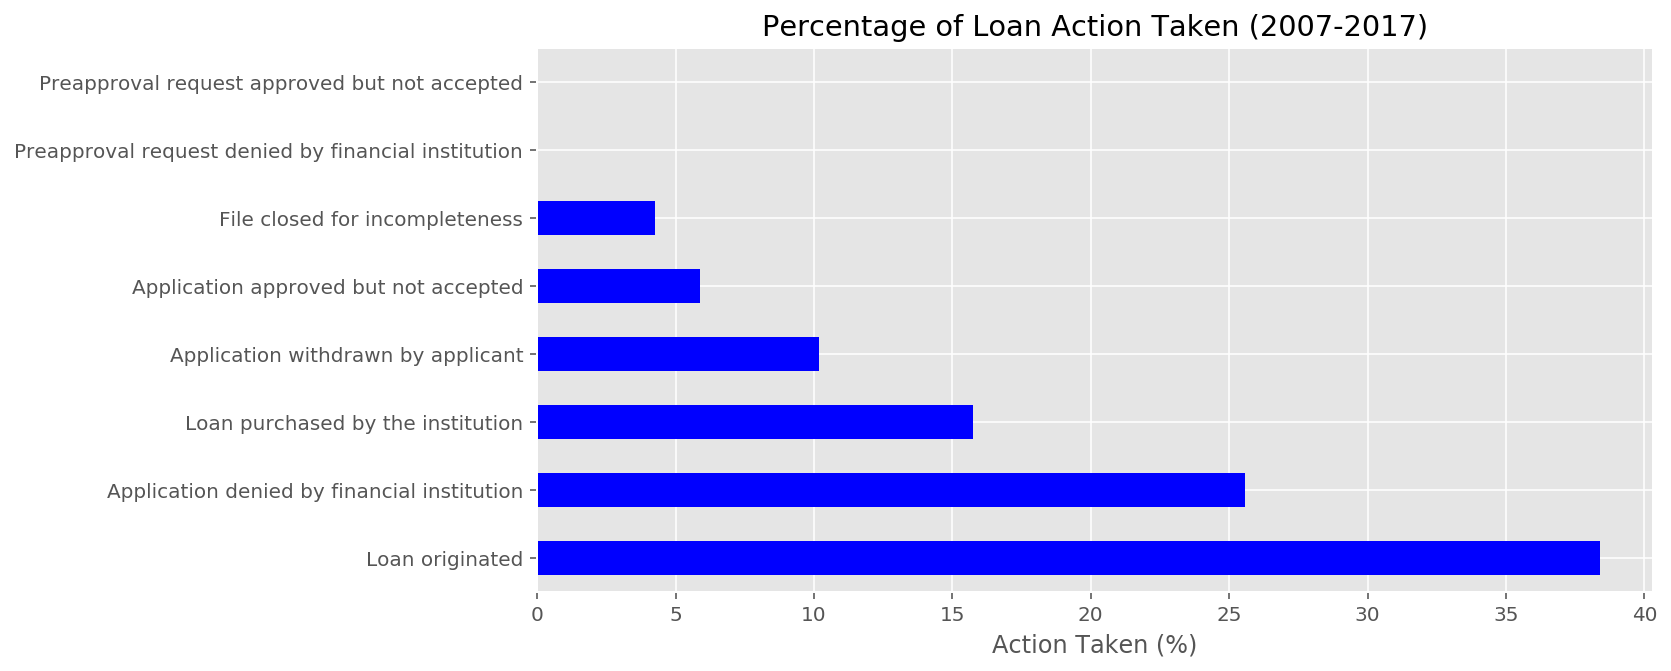

In [11]:
#plot of the percentages of loan action taken
plt.figure(figsize=(10, 5))
ax = action_taken_percent.plot(kind='barh', color='b', title='Percentage of Loan Action Taken (2007-2017)')
ax.set_xlabel('Action Taken (%)');

Loan origination accounts for over 38% of the decisions for loan applications in this dataset, while application denied accounts for about 25% of decisions. Below, I will group the appropriate categories together and drop the nonrelevant outcomes to create a target column. 

In [12]:
#mask to filter only relevant actions
loan_purchased_mask = df['action_taken_name'].isin(['Loan purchased by the institution', 'Application withdrawn by applicant', 
                                                            'Preapproval request denied by financial institution', 'Preapproval request approved but not accepted'])
#drop rows from index based on relevant action filter
df.drop(df[loan_purchased_mask].index, inplace=True)

In [13]:
#recalculate action taken percentages
action_taken_counts = df['action_taken_name'].value_counts(normalize=True)*100
action_taken_counts

Loan originated                                51.836615
Application denied by financial institution    34.502823
Application approved but not accepted           7.936252
File closed for incompleteness                  5.724310
Name: action_taken_name, dtype: float64

In [14]:
#create 'Approved' column based on appropriate action taken options
df['Approved'] = df['action_taken_name'].map(lambda x: 'Approved' if x in 
                        ['Loan originated','Application approved but not accepted'] else 'Not Approved')

In [15]:
#Approved/Not Approved percentages
df['Approved'].value_counts(normalize=True) * 100

Approved        59.772868
Not Approved    40.227132
Name: Approved, dtype: float64

In [16]:
df.shape

(769595, 79)

In [17]:
1-df.shape[0]/df_original.shape[0]

0.25924696035174444

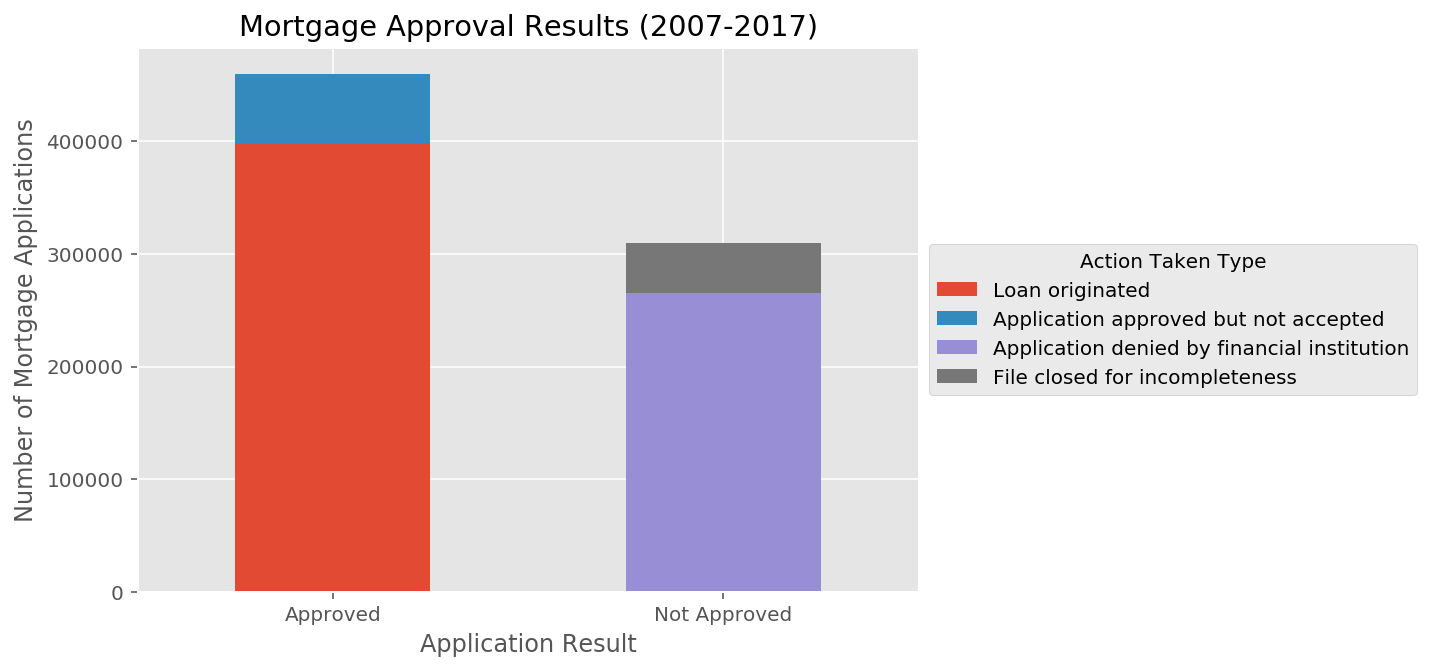

In [18]:
#stacked bar chart of actions within approved/not approved columns
approval_results = df.groupby(['Approved', 'action_taken_name'])['action_taken'].count().unstack().sort_values('Approved',axis=1,ascending=False)

ax = approval_results.plot(kind='bar', stacked=True, title='Mortgage Approval Results (2007-2017)', figsize=(7,5), rot=0)
ax.set_xlabel('Application Result')
ax.set_ylabel('Number of Mortgage Applications')
plt.legend(title='Action Taken Type',loc='center left', bbox_to_anchor=(1, .5));

After dropping the nonrelevant outcomes, loan origination accounts for the majority of application decisions. Combining this with applications that are approved but not accepted by the borrower forms my positive target of applications that are approved. Mortgages that are approved account for almost 60% of the data. A 60/40 split of the target is reasonable and does not require any resampling. Also, dropping the nonrelevant outcomes reduced my dataset by roughly 26%. 

Next step is to address missing data and data values that do not make sense as well as remove features that are not relevant for the analysis, 

In [19]:
def return_cols_with_null_values(dataframe):
    null_values = dataframe.isnull().sum().sort_values(ascending=False)/df.shape[0] * 100
    return null_values[null_values > 0]

In [20]:
return_cols_with_null_values(df)

co_applicant_race_5               99.999090
co_applicant_race_name_5          99.999090
co_applicant_race_4               99.998571
co_applicant_race_name_4          99.998571
co_applicant_race_name_3          99.996622
co_applicant_race_3               99.996622
applicant_race_name_5             99.995452
applicant_race_5                  99.995452
applicant_race_name_4             99.993503
applicant_race_4                  99.993503
applicant_race_3                  99.983758
applicant_race_name_3             99.983758
co_applicant_race_2               99.917749
co_applicant_race_name_2          99.917749
applicant_race_2                  99.650855
applicant_race_name_2             99.650855
denial_reason_3                   98.829254
denial_reason_name_3              98.829254
denial_reason_2                   94.571560
denial_reason_name_2              94.571560
rate_spread                       92.776590
edit_status                       76.797017
edit_status_name                

In [21]:
df['applicant_race_name_2'].value_counts()

White                                        1800
Black or African American                     417
Asian                                         186
Native Hawaiian or Other Pacific Islander     180
American Indian or Alaska Native              104
Name: applicant_race_name_2, dtype: int64

In [22]:
df['applicant_race_2'].value_counts()

5.0    1800
3.0     417
2.0     186
4.0     180
1.0     104
Name: applicant_race_2, dtype: int64

In [23]:
df['co_applicant_race_name_2'].value_counts()

White                                        399
Black or African American                    106
Asian                                         60
Native Hawaiian or Other Pacific Islander     46
American Indian or Alaska Native              22
Name: co_applicant_race_name_2, dtype: int64

In [24]:
df['co_applicant_race_2'].value_counts()

5.0    399
3.0    106
2.0     60
4.0     46
1.0     22
Name: co_applicant_race_2, dtype: int64

The race-based features consist of one column of numbers matched to the corresponding string of the race. There a very limited set of records that have this data, so I am not going to spend too much time here. I am going to add an 'N/a' value to the columns that are object data types and drop the interger based ones. This is because I will one-hot encode the text ones prior to modeling and having the whole name helps with identifying the importance of that feature.

In [25]:
race_name_cols = [cols for cols in df.columns if 'race' in cols and 'name' in cols]
df[race_name_cols] = df[race_name_cols].fillna('N/A')

race_num_cols = [cols for cols in df.columns if 'race' in cols and 'name' not in cols]
df.drop(race_num_cols, axis=1, inplace=True)

In [26]:
return_cols_with_null_values(df)

denial_reason_name_3              98.829254
denial_reason_3                   98.829254
denial_reason_name_2              94.571560
denial_reason_2                   94.571560
rate_spread                       92.776590
edit_status_name                  76.797017
edit_status                       76.797017
denial_reason_1                   73.813499
denial_reason_name_1              73.813499
application_date_indicator         7.789162
sequence_number                    7.789162
applicant_income_000s              7.266679
number_of_owner_occupied_units     0.699589
number_of_1_to_4_family_units      0.574718
tract_to_msamd_income              0.399301
msamd_name                         0.053275
msamd                              0.046778
population                         0.046258
minority_population                0.046258
hud_median_family_income           0.044959
census_tract_number                0.044569
dtype: float64

Next, I remove the columns with one or two value. As you can see below, these are typically uninformative columns since I have selected a defined geography for my analysis (e.g. state or county ids). HOEPA status represents whether a loan is subject to the Home Ownership and Equity Protection Act of 1994 (HOEPA). The vast majority of loans are not subject to HOEPA, so I feel comfortable dropping that as well. 

In [27]:
cols_with_one_or_two_values = [cols for cols in df.columns[df.apply(lambda x: x.nunique()) <=2] if cols != 'Approved']
[df[x].value_counts() for x in cols_with_one_or_two_values] 

[86    769595
 Name: county_code, dtype: int64, Miami-Dade County    769595
 Name: county_name, dtype: int64, 6.0    178569
 Name: edit_status, dtype: int64, Quality edit failure only    178569
 Name: edit_status_name, dtype: int64, 2    769505
 1        90
 Name: hoepa_status, dtype: int64, Not a HOEPA loan    769505
 HOEPA loan              90
 Name: hoepa_status_name, dtype: int64, 33124.0    769185
 33100.0        50
 Name: msamd, dtype: int64, Miami, Miami Beach, Kendall - FL    769185
 Name: msamd_name, dtype: int64, 12    769595
 Name: state_code, dtype: int64, FL    769595
 Name: state_abbr, dtype: int64, Florida    769595
 Name: state_name, dtype: int64]

In [28]:
df.drop(cols_with_one_or_two_values, axis=1, inplace=True)

In [29]:
return_cols_with_null_values(df)

denial_reason_name_3              98.829254
denial_reason_3                   98.829254
denial_reason_2                   94.571560
denial_reason_name_2              94.571560
rate_spread                       92.776590
denial_reason_name_1              73.813499
denial_reason_1                   73.813499
sequence_number                    7.789162
application_date_indicator         7.789162
applicant_income_000s              7.266679
number_of_owner_occupied_units     0.699589
number_of_1_to_4_family_units      0.574718
tract_to_msamd_income              0.399301
minority_population                0.046258
population                         0.046258
hud_median_family_income           0.044959
census_tract_number                0.044569
dtype: float64

Now I inspect the denial reasons, which I will drop since they occur subsequent to the loan decision being made. It is interesting to note that for the loans that we have a denial reason, all of them are based on either an applicant's historical finances or financing of this particular loan. This is concerning since we have limited financial features in our dataset. We have applicant income (with some missing values as seen above), lien information, the rate spread (also missing values), and loan amount. I will think about how to replace those missing values and how I may be able to engineer some features out of them later on. 

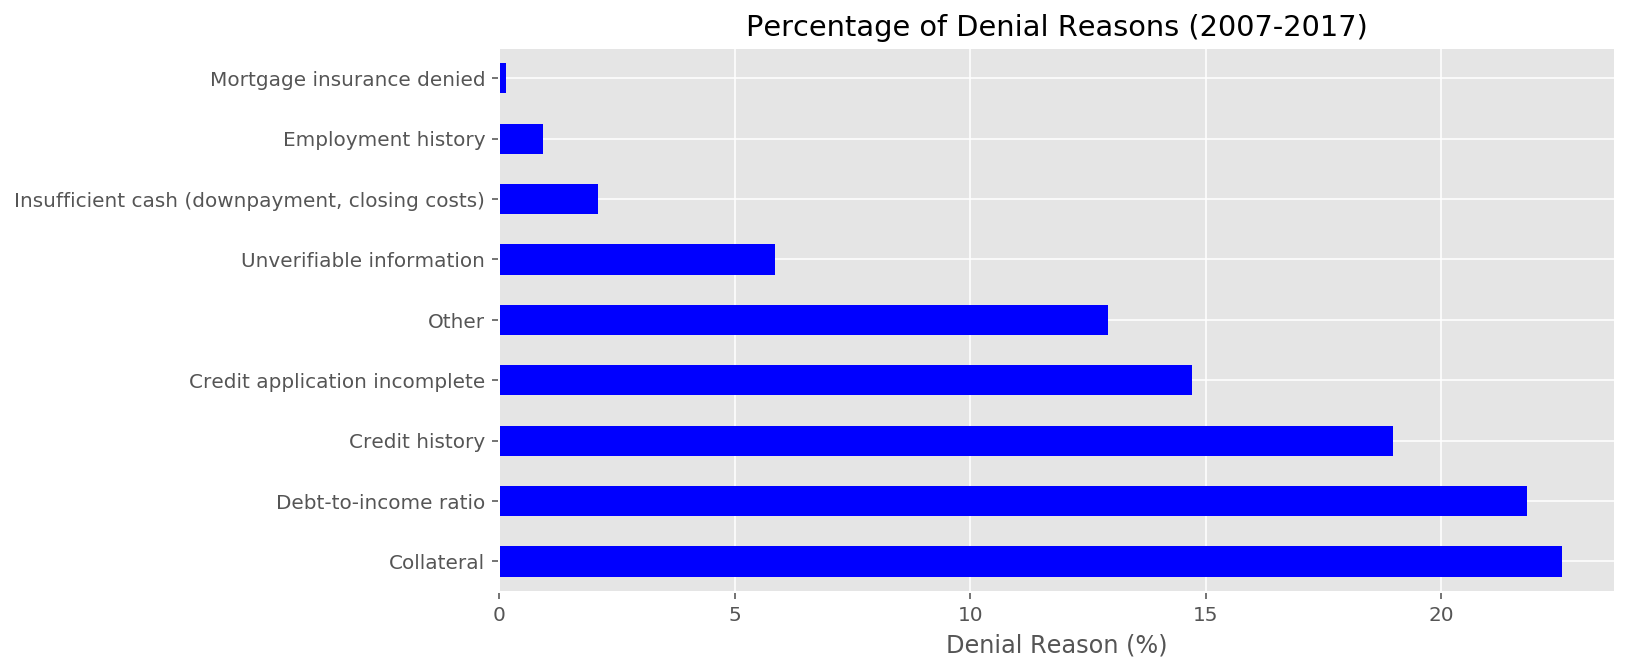

In [30]:
denial_reason_percent = df['denial_reason_name_1'].value_counts(normalize=True)*100

plt.figure(figsize=(10, 5))
ax = denial_reason_percent.plot(kind='barh', color='b', title='Percentage of Denial Reasons (2007-2017)')
ax.set_xlabel('Denial Reason (%)');

In [31]:
df.drop([cols for cols in df.columns if 'denial' in cols or 'edit' in cols or 'purchaser' in cols], axis=1, inplace=True)

In [32]:
return_cols_with_null_values(df)

rate_spread                       92.776590
sequence_number                    7.789162
application_date_indicator         7.789162
applicant_income_000s              7.266679
number_of_owner_occupied_units     0.699589
number_of_1_to_4_family_units      0.574718
tract_to_msamd_income              0.399301
population                         0.046258
minority_population                0.046258
hud_median_family_income           0.044959
census_tract_number                0.044569
dtype: float64

From the data dictionary, sequence number is 'a one-up number scheme for each respondent to make each loan unique.' We should expect some repeating values here and I quickly checked for repeating values from each respondent by year and did not find any repeating values. Therefore, I am comfortable dropping this column. 

In [33]:
sequence_group = df.groupby(by=['respondent_id','as_of_year','sequence_number']).count()['action_taken'].sort_values(ascending=False)
sequence_group[sequence_group>1]

Series([], Name: action_taken, dtype: int64)

In [34]:
df.drop('sequence_number', axis=1, inplace=True)

Application data indicator is 'a code representing the date of the application. "0" means the application was made on or after 1/1/2004; "1" means the application was made before 1/1/2004; "2" means the application date is not available.' However, there are some loans with 3 as the value. Based on my research, prior to 2010 there were four options (https://www.ffiec.gov/hmdarawdata/FORMATS/2009HMDACodeSheet.pdf): 

    Application Date Indicator
     0 -- Application Date >= 01-01-2004 and not (>= 10-01-2009 and <= 12-31-2009)
     1 -- Application Date < 01-01-2004
     2 -- Not Available
     3 -- Application Date >= 10-01-2009 and <= 12-31-2009

I changed the values with 3 (changed to 0 since applications were after 1/1/2004) and filled in the rest with 2. 

In [35]:
df['application_date_indicator'].value_counts()

0.0    704618
3.0      5010
1.0        22
Name: application_date_indicator, dtype: int64

In [36]:
df['application_date_indicator'].map(lambda x: 0 if x == 3 else x)
df['application_date_indicator'] = df['application_date_indicator'].fillna(2)

In [37]:
return_cols_with_null_values(df)

rate_spread                       92.776590
applicant_income_000s              7.266679
number_of_owner_occupied_units     0.699589
number_of_1_to_4_family_units      0.574718
tract_to_msamd_income              0.399301
population                         0.046258
minority_population                0.046258
hud_median_family_income           0.044959
census_tract_number                0.044569
dtype: float64

For the values at the census tract level (all those above except for applicant income and rate spread), I am going to sort my dataframe by census number and forward fill values. Based on my research, the census tracts are neighboring other census tracts with nearby numbers, so I feel that this is an appropriate method to fill in this data on the notion that neighboring tracts will have similar values. Becuase these null values represent such a limited portion of my overall dataset, I feel comfortable with this approach.

In [38]:
census_cols_to_fill = return_cols_with_null_values(df)[2:].index.tolist()
df[census_cols_to_fill] = df[census_cols_to_fill].sort_values(by='census_tract_number').fillna(method='ffill')

In [39]:
return_cols_with_null_values(df)

rate_spread              92.776590
applicant_income_000s     7.266679
dtype: float64

This leaves me with just rate spread and applicant income to deal with. Looking at the data dictionary for rate spread, it 'is the difference between the loan's annual percentage rate (APR) and the average prime offer rate (APOR).' From the 2018 HMDA instructions (https://www.consumerfinance.gov/data-research/hmda/static/for-filers/2018/2018-hmda-fig.pdf):

    a. If the APR exceeds the APOR, enter a positive number.
        Example:
        If the APR is 3.678% and the APOR is 3.25%, enter 0.428.
        If the APR is 4.560% and the APOR is 4.25%, enter either 0.31 or 0.310
    b. If the APR is less than the APOR, enter a negative number.
        Example:
        If the APR 3.1235% and the APOR is 3.25%, enter -0.1265. Alternatively, the rate spread may be truncated to 
        -0.126 or rounded to -0.127.
    c. Enter “NA” if the requirement to report rate spread does not apply to the covered loan or application that 
       your institution is reporting.
       
Contrary to these instructions, the rate spread values in this dataset range from 1.5-17.52 and over 92% of the loans are missing this information. I am skeptical on what I can do with this information, although I would like to be able to use it. I am going to create bins for this data for now and potentially revisit this if there is more time.

In [40]:
df['rate_spread'].min()

1.5

In [41]:
df['rate_spread'].max()

17.52

In [42]:
df['binned_rate_spread'] = pd.cut(df['rate_spread'], 4).values.add_categories('N/a')
df['binned_rate_spread'].fillna('N/a', inplace=True)

In [43]:
df['binned_rate_spread'].value_counts()

N/a                714004
(1.484, 5.505]      43271
(5.505, 9.51]       11962
(9.51, 13.515]        352
(13.515, 17.52]         6
Name: binned_rate_spread, dtype: int64

Unfortuately, I am going to have to take the same approach for the applicant income as well. With over 7% of the loans missing this field and the lack of many correlated features (at least for the numeric features as seen below), I don't see how I can infer this value. I think the binning will still help and, like with the rate spread), may revisit this as time permits

In [44]:
df.corr()['applicant_income_000s'].sort_values(ascending=False)

applicant_income_000s             1.000000
loan_amount_000s                  0.439839
tract_to_msamd_income             0.176388
owner_occupancy                   0.151382
applicant_ethnicity               0.073226
hud_median_family_income          0.004390
rate_spread                       0.000572
application_date_indicator        0.000339
as_of_year                       -0.001002
number_of_owner_occupied_units   -0.009467
property_type                    -0.013319
action_taken                     -0.021082
census_tract_number              -0.021254
preapproval                      -0.021424
co_applicant_ethnicity           -0.022037
agency_code                      -0.028082
co_applicant_sex                 -0.029039
lien_status                      -0.029299
applicant_sex                    -0.029803
loan_purpose                     -0.033958
loan_type                        -0.076872
population                       -0.077629
number_of_1_to_4_family_units    -0.100582
minority_po

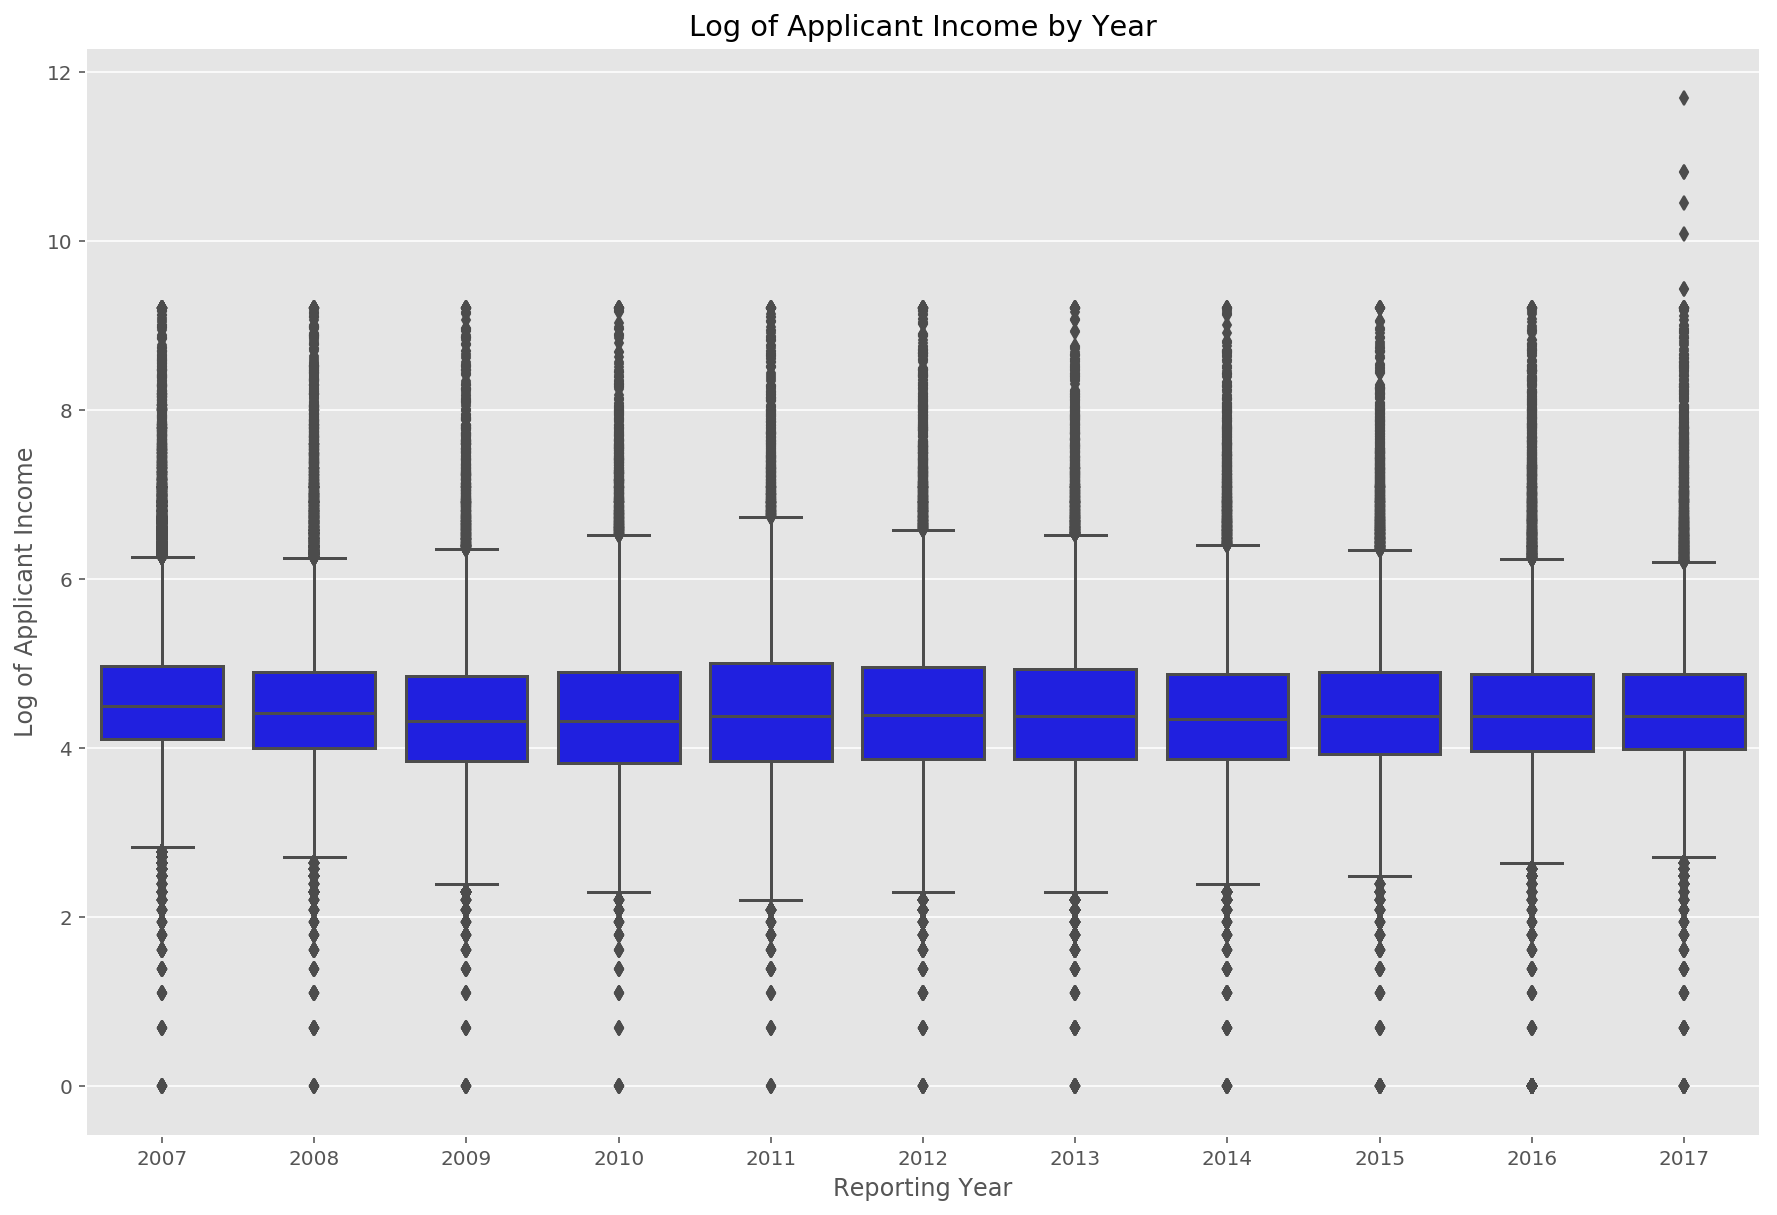

In [45]:
plt.figure(figsize=(15, 10))
ax = sns.boxplot(x='as_of_year', y=np.log(df['applicant_income_000s']), data=df, color='b')
plt.title('Log of Applicant Income by Year')
ax.set_xlabel('Reporting Year')
ax.set_ylabel('Log of Applicant Income');

There appear to be some very big outliers in 2017, which will account for many of the loans in the highest bracket. A bit concerning as I will be predicting 2017 values based on a training set of all previous years.

In [46]:
df.groupby('as_of_year')['applicant_income_000s'].max()

as_of_year
2007      9999.0
2008      9999.0
2009      9999.0
2010      9999.0
2011      9999.0
2012      9999.0
2013      9999.0
2014      9999.0
2015      9999.0
2016      9999.0
2017    120000.0
Name: applicant_income_000s, dtype: float64

In [47]:
df['target'] = df['Approved'].map(lambda x: 1 if x == 'Approved' else 0)

/anaconda3/envs/dsi/lib/python3.6/site-packages/numpy/lib/function_base.py:780: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/anaconda3/envs/dsi/lib/python3.6/site-packages/numpy/lib/function_base.py:781: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


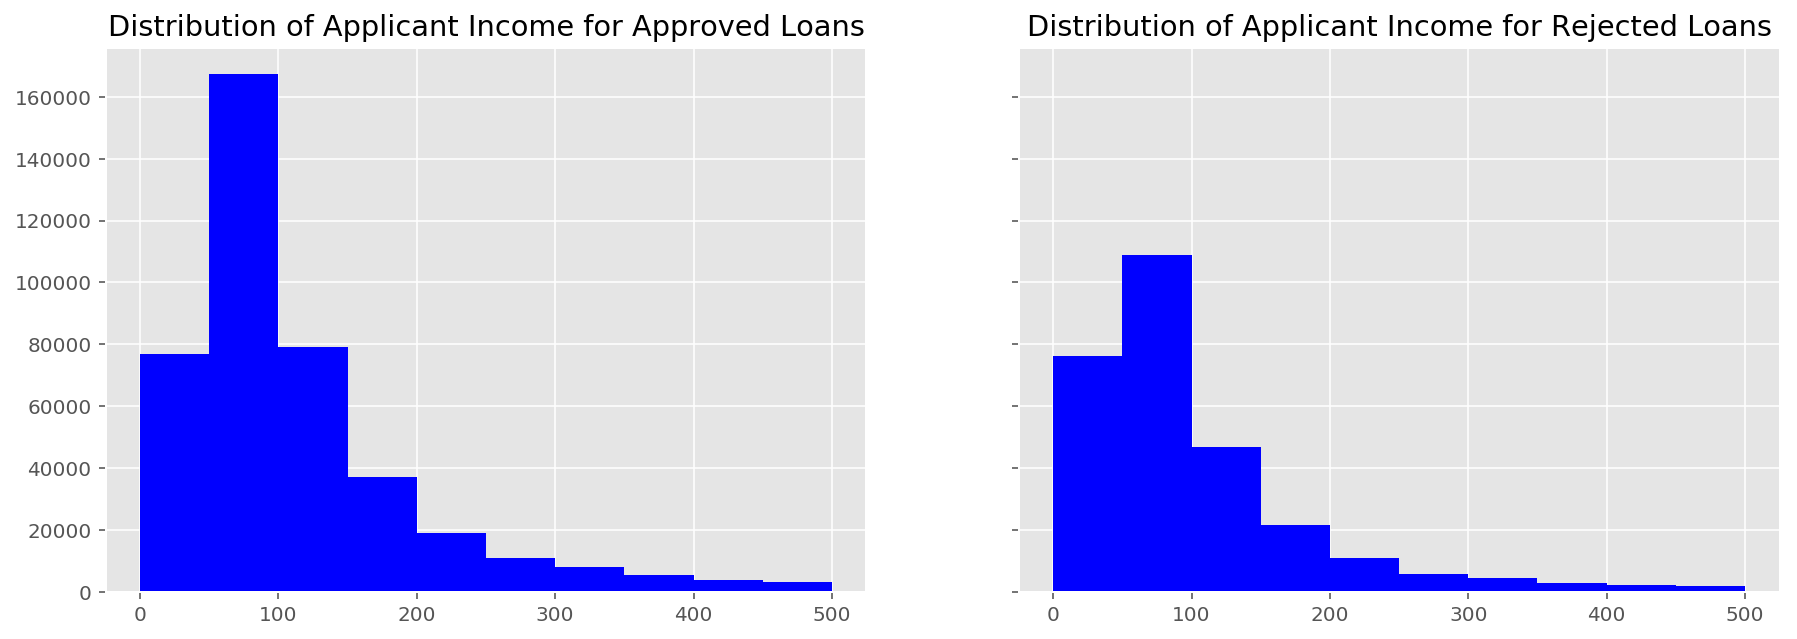

In [48]:
mask_target_1 = df['target'] == 1
mask_target_0 = df['target'] == 0

fig, ax = plt.subplots(1, 2, figsize=(15, 5), sharex=True, sharey=True)
ax[0].set_title('Distribution of Applicant Income for Approved Loans')
ax[0].hist(df[mask_target_1]['applicant_income_000s'], range=(0,500), color='b')
ax[1].set_title('Distribution of Applicant Income for Rejected Loans')
ax[1].hist(df[mask_target_0]['applicant_income_000s'], range=(0,500), color='b');

Relatively similar distribution for Approved vs. Rejected loans, but higher proportion of low income applicants for rejected loans. 

In [49]:
df['binned_income'] = pd.cut(df['applicant_income_000s'], [0,15,50,100,250,1000,5000,df['applicant_income_000s'].max()]).values.add_categories('N/a')
df['binned_income'].fillna('N/a', inplace=True)

In [50]:
df['binned_income'].value_counts()

(50.0, 100.0]         273483
(100.0, 250.0]        209466
(15.0, 50.0]          152730
(250.0, 1000.0]        61340
N/a                    55924
(0.0, 15.0]             9387
(1000.0, 5000.0]        6720
(5000.0, 120000.0]       545
Name: binned_income, dtype: int64

In [51]:
df.drop(['rate_spread', 'applicant_income_000s'], axis=1, inplace=True)

In [52]:
assert df.isnull().sum().sum() == 0

I am now done with filling in the missing data, but there are a few features that 

In [53]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 769595 entries, 0 to 1038934
Data columns (total 50 columns):
action_taken                      769595 non-null int64
action_taken_name                 769595 non-null object
agency_code                       769595 non-null int64
agency_abbr                       769595 non-null object
agency_name                       769595 non-null object
applicant_ethnicity               769595 non-null int64
applicant_ethnicity_name          769595 non-null object
applicant_race_name_1             769595 non-null object
applicant_race_name_2             769595 non-null object
applicant_race_name_3             769595 non-null object
applicant_race_name_4             769595 non-null object
applicant_race_name_5             769595 non-null object
applicant_sex                     769595 non-null int64
applicant_sex_name                769595 non-null object
application_date_indicator        769595 non-null float64
as_of_year                        76

In [54]:
df.describe(include='all')

,action_taken,action_taken_name,agency_code,agency_abbr,agency_name,applicant_ethnicity,applicant_ethnicity_name,applicant_race_name_1,applicant_race_name_2,applicant_race_name_3,applicant_race_name_4,applicant_race_name_5,applicant_sex,applicant_sex_name,application_date_indicator,as_of_year,census_tract_number,co_applicant_ethnicity,co_applicant_ethnicity_name,co_applicant_race_name_1,co_applicant_race_name_2,co_applicant_race_name_3,co_applicant_race_name_4,co_applicant_race_name_5,co_applicant_sex,co_applicant_sex_name,lien_status,lien_status_name,loan_purpose,loan_purpose_name,loan_type,loan_type_name,owner_occupancy,owner_occupancy_name,preapproval,preapproval_name,property_type,property_type_name,respondent_id,hud_median_family_income,loan_amount_000s,number_of_1_to_4_family_units,number_of_owner_occupied_units,minority_population,population,tract_to_msamd_income,Approved,binned_rate_spread,target,binned_income
count,769595.000000,769595,769595.000000,769595,769595,769595.000000,769595,769595,769595,769595,769595,769595,769595.000000,769595,769595.000000,769595.000000,769595.000000,769595.000000,769595,769595,769595,769595,769595,769595,769595.000000,769595,769595.000000,769595,769595.000000,769595,769595.000000,769595,769595.000000,769595,769595.000000,769595,769595.000000,769595,769595,769595.000000,769595.000000,769595.000000,769595.000000,769595.000000,769595.000000,769595.000000,769595,769595,769595.000000,769595
unique,NaN,4,NaN,7,7,NaN,4,7,6,6,6,3,NaN,4,NaN,NaN,NaN,NaN,5,8,6,6,4,4,NaN,5,NaN,3,NaN,3,NaN,4,NaN,3,NaN,3,NaN,3,2311,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2,5,NaN,8
top,NaN,Loan originated,NaN,HUD,Department of Housing and Urban Development,NaN,Hispanic or Latino,White,N/A,N/A,N/A,N/A,NaN,Male,NaN,NaN,NaN,NaN,No co-applicant,No co-applicant,N/A,N/A,N/A,N/A,NaN,No co-applicant,NaN,Secured by a first lien,NaN,Refinancing,NaN,Conventional,NaN,Owner-occupied as a principal dwelling,NaN,Not applicable,NaN,One-to-four family dwelling (other than manufa...,0000451965,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Approved,N/a,NaN,"(50.0, 100.0]"
freq,NaN,398932,NaN,246496,246496,NaN,445658,563812,766908,769470,769545,769560,NaN,450483,NaN,NaN,NaN,NaN,538737,538737,768962,769569,769584,769588,NaN,538737,NaN,709060,NaN,399434,NaN,651869,NaN,643920,NaN,634235,NaN,763441,38548,NaN,NaN,NaN,NaN,NaN,NaN,NaN,460009,714004,NaN,273483
mean,1.998391,NaN,5.406227,NaN,NaN,1.553205,NaN,NaN,NaN,NaN,NaN,NaN,1.509677,NaN,0.175342,2011.090076,84.469862,3.967986,NaN,NaN,NaN,NaN,NaN,NaN,4.056063,NaN,1.104949,NaN,2.103695,NaN,1.170394,NaN,1.168433,NaN,2.804869,NaN,1.012552,NaN,NaN,48902.789779,266.518790,1570.766588,1455.874160,76.464702,6711.448962,126.958109,NaN,NaN,0.597729,NaN
std,1.174130,NaN,2.990778,NaN,NaN,0.737002,NaN,NaN,NaN,NaN,NaN,NaN,0.686468,NaN,0.582615,3.551018,248.651616,1.625554,NaN,NaN,NaN,NaN,NaN,NaN,1.474461,NaN,0.382774,NaN,0.961036,NaN,0.419866,NaN,0.387722,NaN,0.442208,NaN,0.146649,NaN,NaN,2579.430556,724.522487,904.236790,772.306495,18.845098,2965.917579,60.933508,NaN,NaN,0.490356,NaN
min,1.000000,NaN,1.000000,NaN,NaN,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,1.000000,NaN,0.000000,2007.000000,1.060000,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,1.000000,NaN,1.000000,NaN,1.000000,NaN,1.000000,NaN,1.000000,NaN,1.000000,NaN,1.000000,NaN,NaN,45200.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,NaN,0.000000,NaN
25%,1.000000,NaN,2.000000,NaN,NaN,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,1.000000,NaN,0.000000,2007.000000,41.050000,2.000000,NaN,NaN,NaN,NaN,NaN,NaN,2.000000,NaN,1.000000,NaN,1.000000,NaN,1.000000,NaN,1.000000,NaN,3.000000,NaN,1.000000,NaN,NaN,45200.000000,125.000000,997.000000,950.000000,64.250000,4739.000000,85.800003,NaN,NaN,0.000000,NaN
50%,1.000000,NaN,7.000000,NaN,NaN,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,1.000000,NaN,0.000000,2011.000000,85.010000,5.000000,NaN,NaN,NaN,NaN,NaN,NaN,5.000000,NaN,1.000000,NaN,3.000000,NaN,1.000000,NaN,1.000000,NaN,3.000000,NaN,1.000000,NaN,NaN,49200.000000,196.000000,1553.000000,1330.000000,83.190002,6264.0000

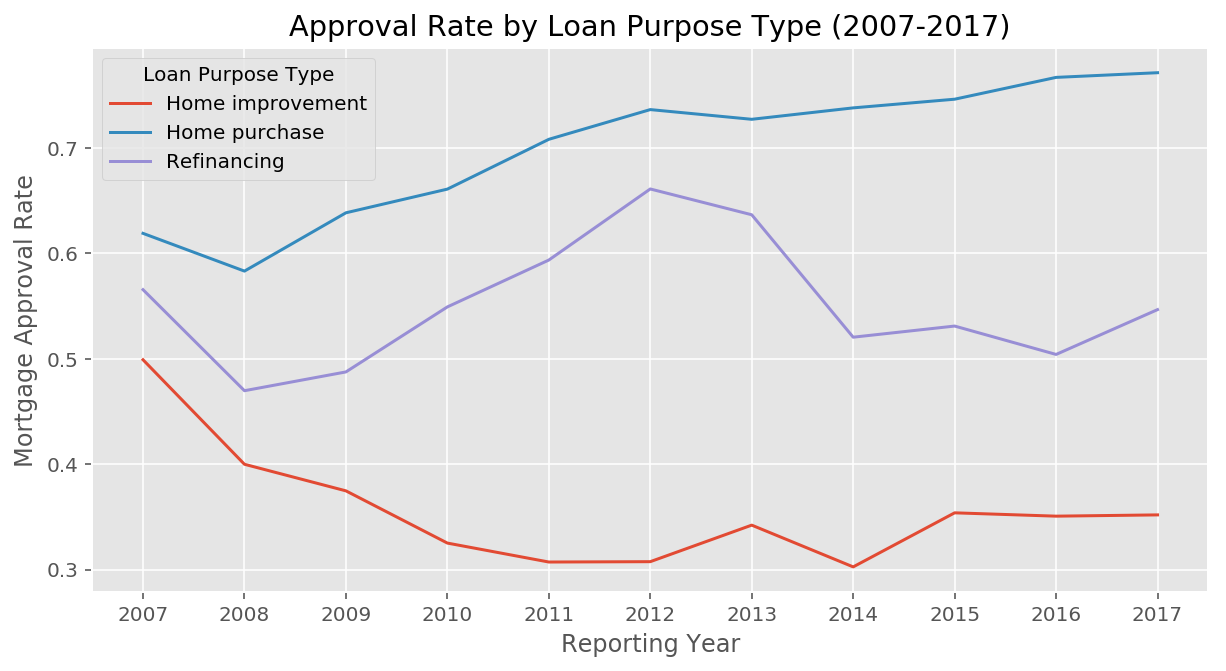

In [55]:
approval_rate_by_type = df.groupby(['as_of_year', 'loan_purpose_name'])['target'].apply(lambda x: x.sum()/x.count()).unstack()

ax = approval_rate_by_type.plot(title='Approval Rate by Loan Purpose Type (2007-2017)', xticks=df['as_of_year'].unique(), figsize=(10,5))

ax.set_xlabel('Reporting Year')
ax.set_ylabel('Mortgage Approval Rate')
plt.legend(title='Loan Purpose Type');

In [56]:
df['loan_purpose_name'].value_counts(normalize=True) * 100

Refinancing         51.901844
Home purchase       41.532364
Home improvement     6.565791
Name: loan_purpose_name, dtype: float64

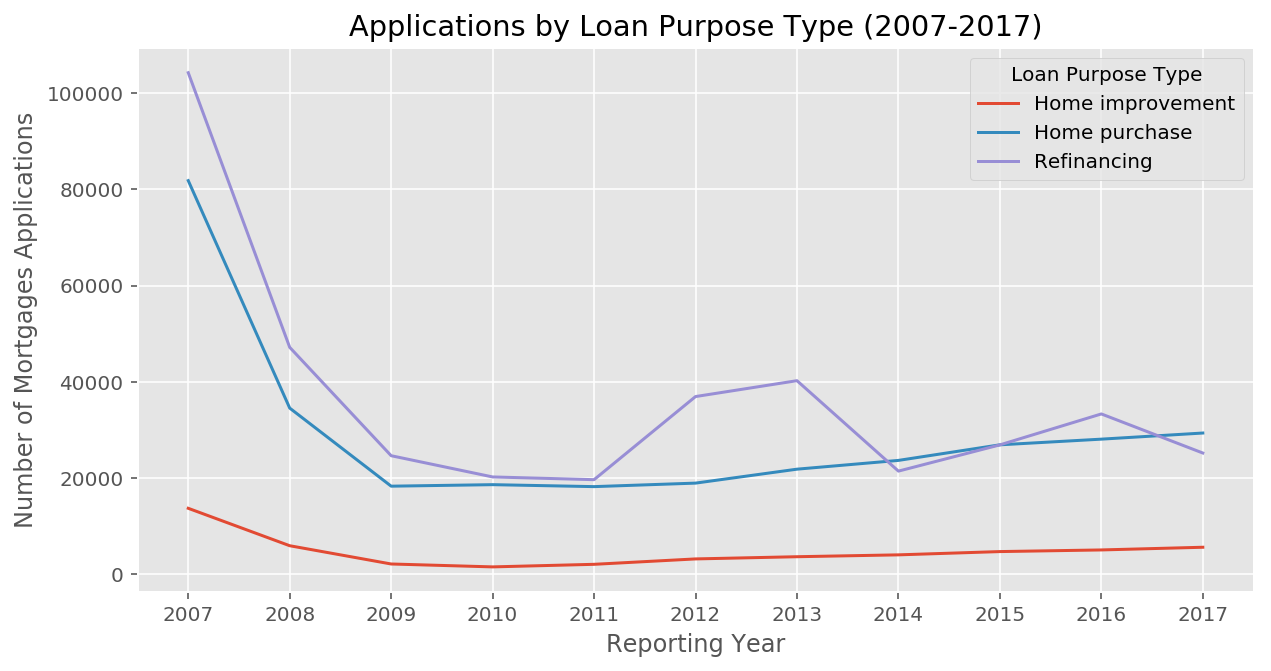

In [57]:
applications_by_type = df.groupby(['loan_purpose_name','as_of_year'])['loan_purpose_name'].count().unstack(level=0)

ax = applications_by_type.plot(title='Applications by Loan Purpose Type (2007-2017)', xticks=df['as_of_year'].unique(), figsize=(10,5));

ax.set_xlabel('Reporting Year')
ax.set_ylabel('Number of Mortgages Applications')
plt.legend(title='Loan Purpose Type');

In [58]:
df = df.applymap(lambda x: 'Information not provided' if x == 'Information not provided by applicant in mail, Internet, or telephone application' else x)

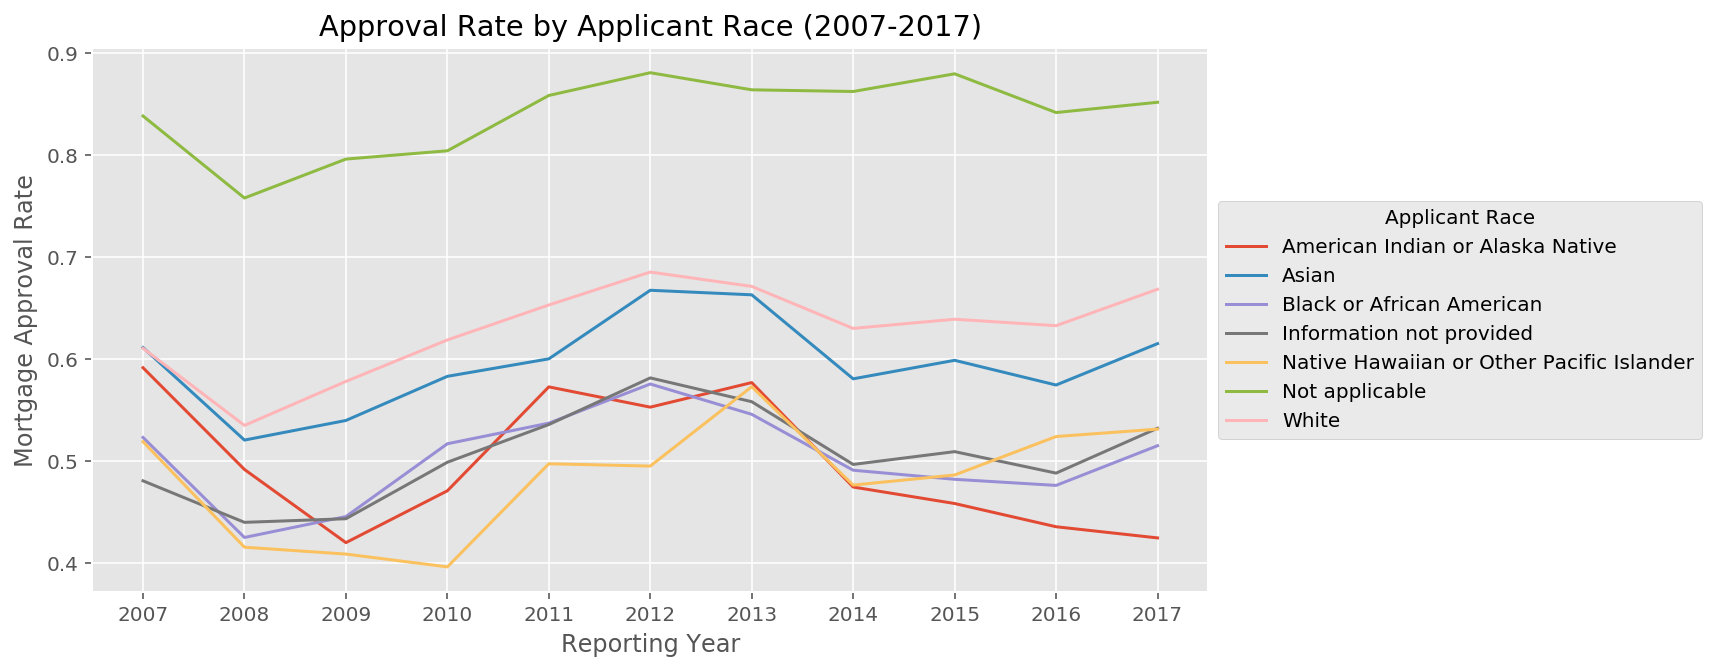

In [59]:
approval_rate_app_race = df.groupby(['as_of_year', 'applicant_race_name_1'])['target'].apply(lambda x: x.sum()/x.count()).unstack()

ax = approval_rate_app_race.plot(title='Approval Rate by Applicant Race (2007-2017)', xticks=df['as_of_year'].unique(), figsize=(10,5))

ax.set_xlabel('Reporting Year')
ax.set_ylabel('Mortgage Approval Rate')
plt.legend(title='Applicant Race', loc='center left', bbox_to_anchor=(1, .5));

Dropping 'Not applicable' to better show these rates over time. 

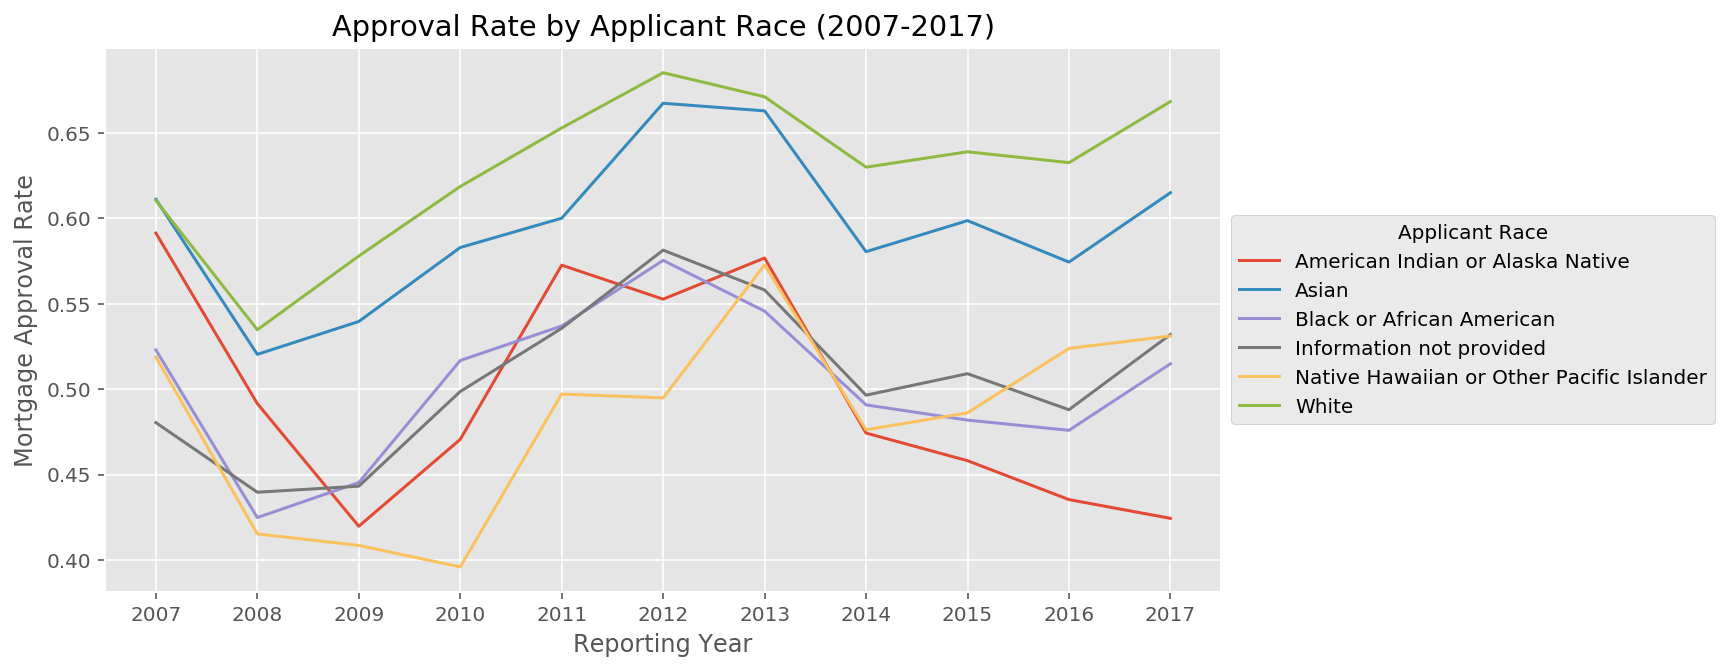

In [60]:
ax = approval_rate_app_race.drop('Not applicable', axis=1).plot(title='Approval Rate by Applicant Race (2007-2017)', xticks=df['as_of_year'].unique(), figsize=(10,5))

ax.set_xlabel('Reporting Year')
ax.set_ylabel('Mortgage Approval Rate')
plt.legend(title='Applicant Race', loc='center left', bbox_to_anchor=(1, .5));

In [61]:
df['applicant_race_name_1'].value_counts(normalize=True) * 100

White                                        73.260871
Information not provided                     12.825187
Black or African American                    10.113241
Not applicable                                1.557443
Asian                                         1.534963
American Indian or Alaska Native              0.367076
Native Hawaiian or Other Pacific Islander     0.341218
Name: applicant_race_name_1, dtype: float64

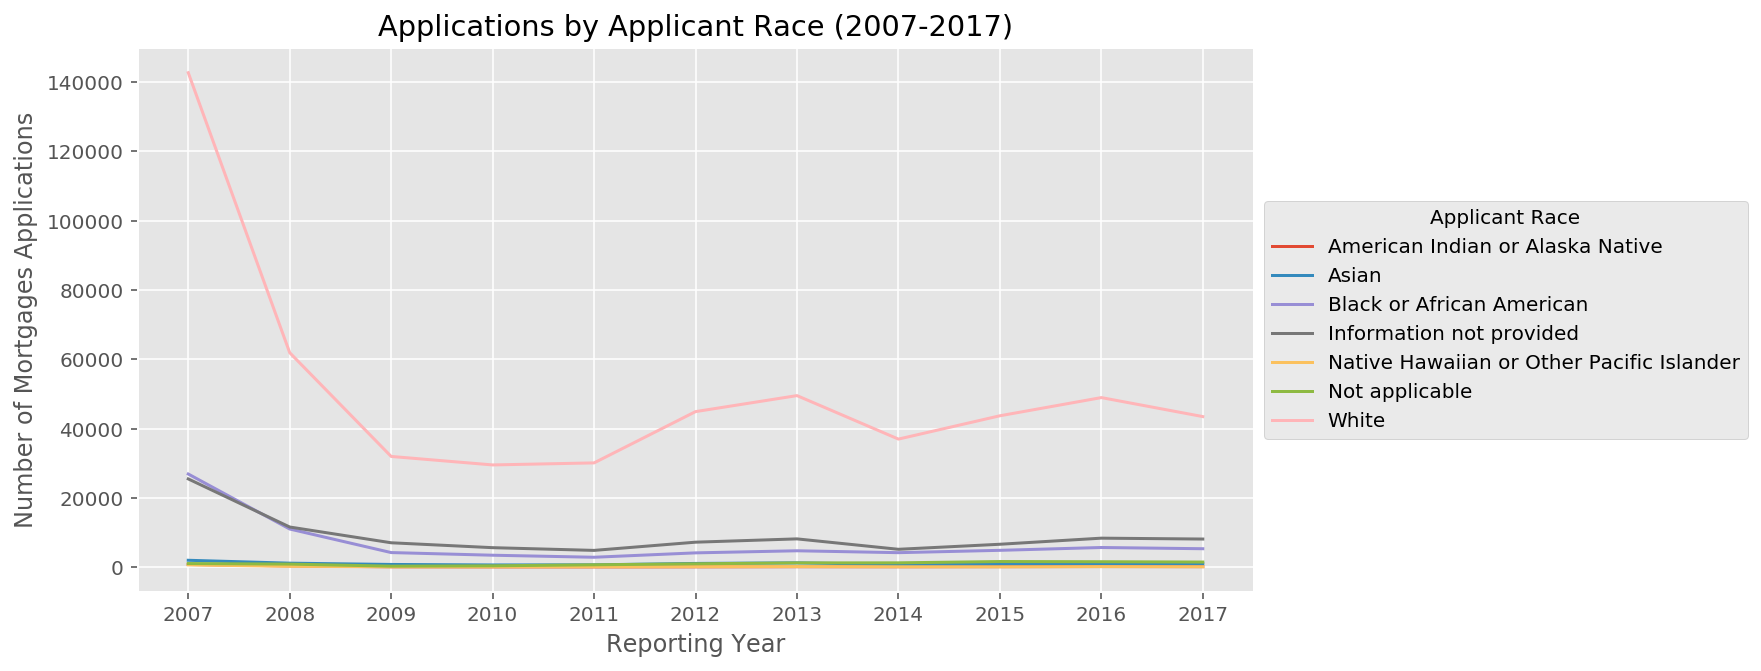

In [62]:
applications_by_app_race = df.groupby(['applicant_race_name_1','as_of_year'])['applicant_race_name_1'].count().unstack(level=0)

ax = applications_by_app_race.plot(title='Applications by Applicant Race (2007-2017)', xticks=df['as_of_year'].unique(), figsize=(10,5));

ax.set_xlabel('Reporting Year')
ax.set_ylabel('Number of Mortgages Applications')
plt.legend(title='Applicant Race', loc='center left', bbox_to_anchor=(1, .5));

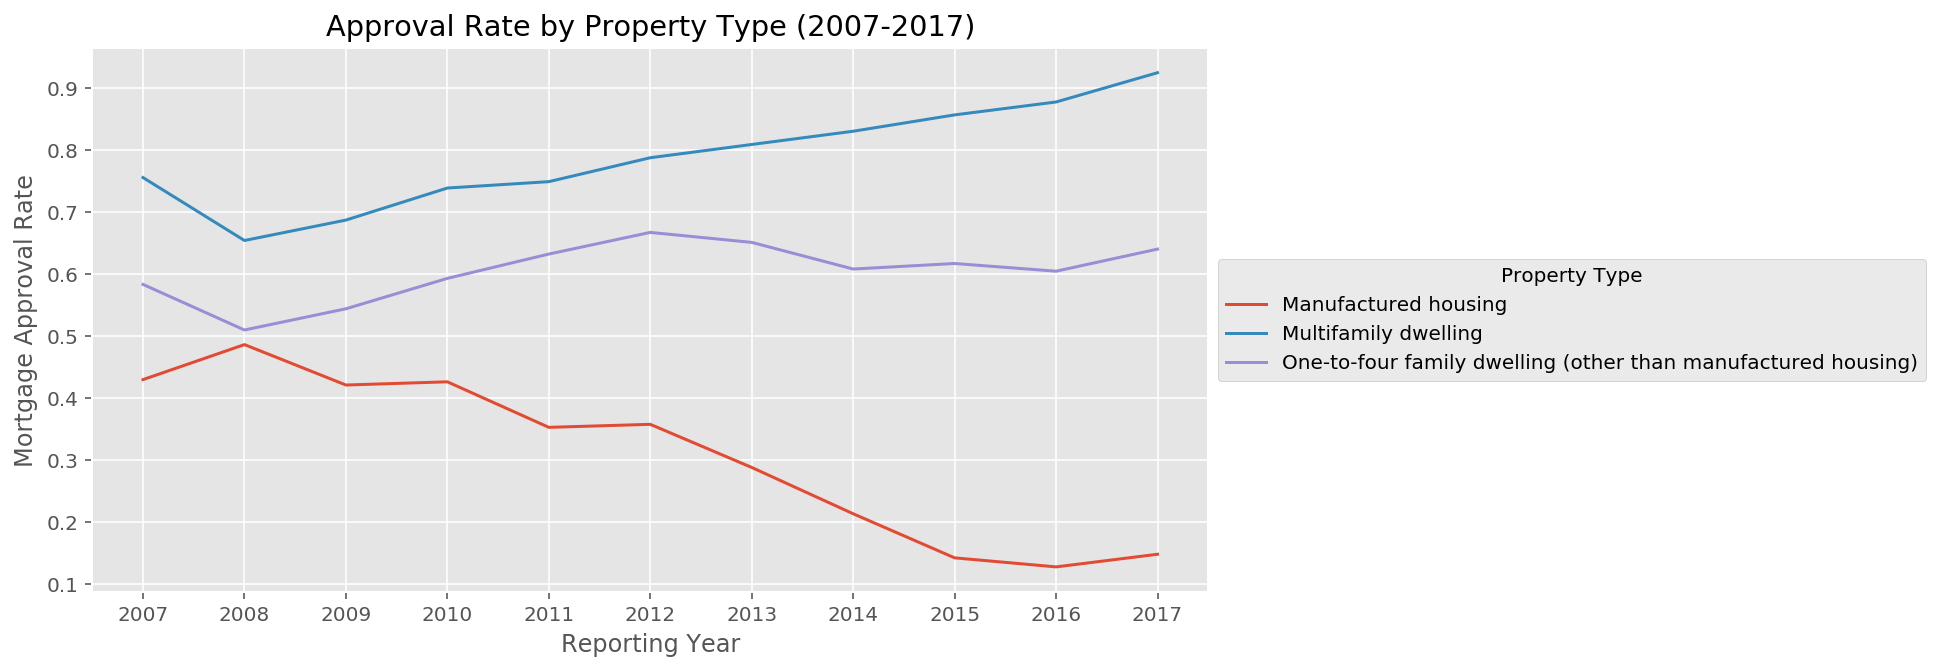

In [63]:
approval_rate_prop_type = df.groupby(['as_of_year', 'property_type_name'])['target'].apply(lambda x: x.sum()/x.count()).unstack()

ax = approval_rate_prop_type.plot(title='Approval Rate by Property Type (2007-2017)', xticks=df['as_of_year'].unique(), figsize=(10,5))

ax.set_xlabel('Reporting Year')
ax.set_ylabel('Mortgage Approval Rate')
plt.legend(title='Property Type', loc='center left', bbox_to_anchor=(1, .5));

In [64]:
df['property_type_name'].value_counts()

One-to-four family dwelling (other than manufactured housing)    763441
Multifamily dwelling                                               3506
Manufactured housing                                               2648
Name: property_type_name, dtype: int64

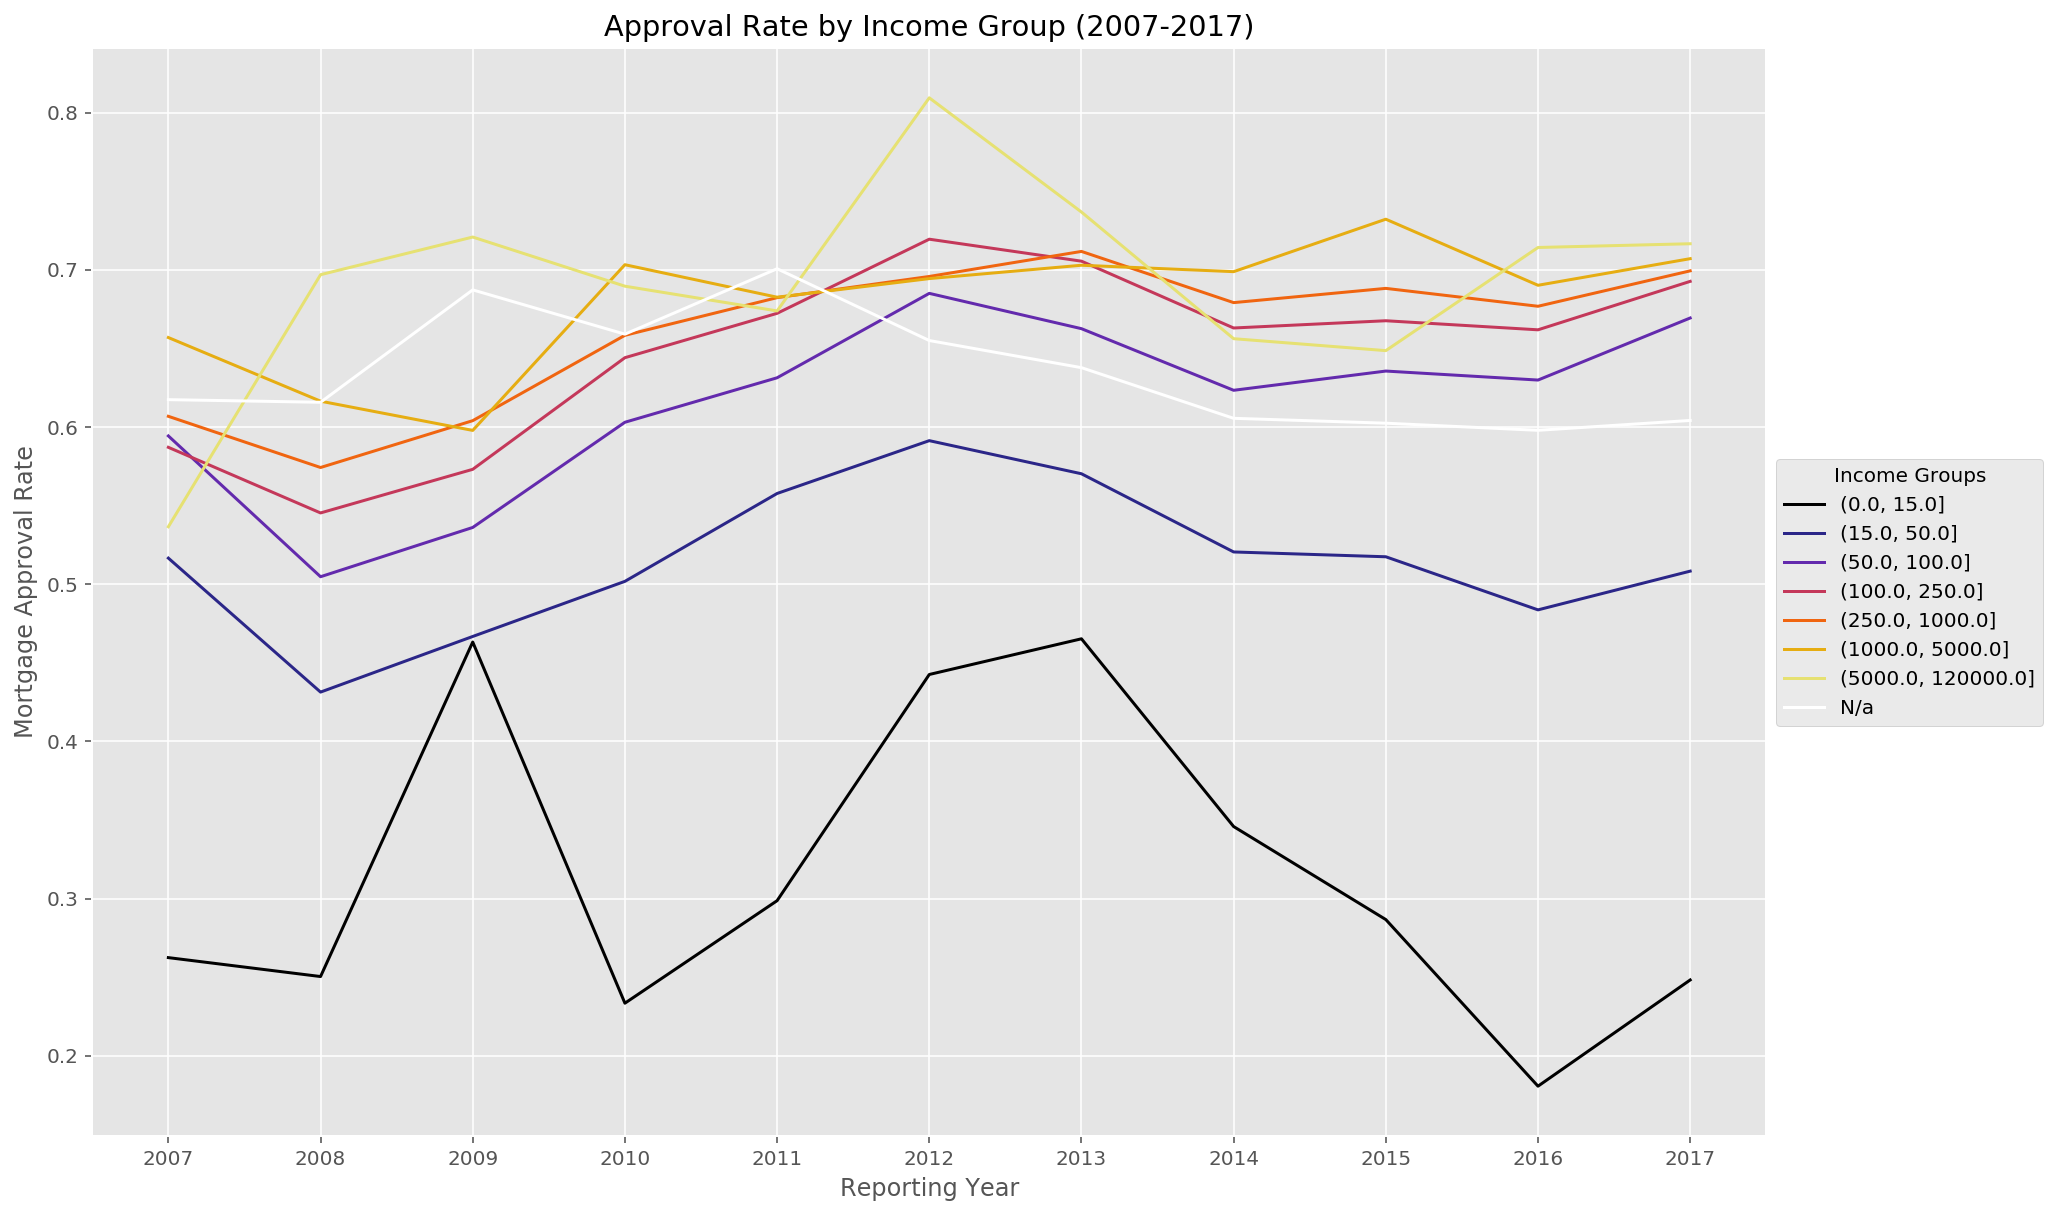

In [65]:
approval_rate_by_type = df.groupby(['as_of_year', 'binned_income'])['target'].apply(lambda x: x.sum()/x.count()).unstack()

ax = approval_rate_by_type.plot(title='Approval Rate by Income Group (2007-2017)', xticks=df['as_of_year'].unique(), 
                                figsize=(15,10), colormap='CMRmap')

ax.set_xlabel('Reporting Year')
ax.set_ylabel('Mortgage Approval Rate')

plt.legend(title='Income Groups', loc='center left', bbox_to_anchor=(1, .5));

In [66]:
df['binned_rate_spread'] = df['binned_rate_spread'].astype(str)
df['binned_income'] = df['binned_income'].astype(str)

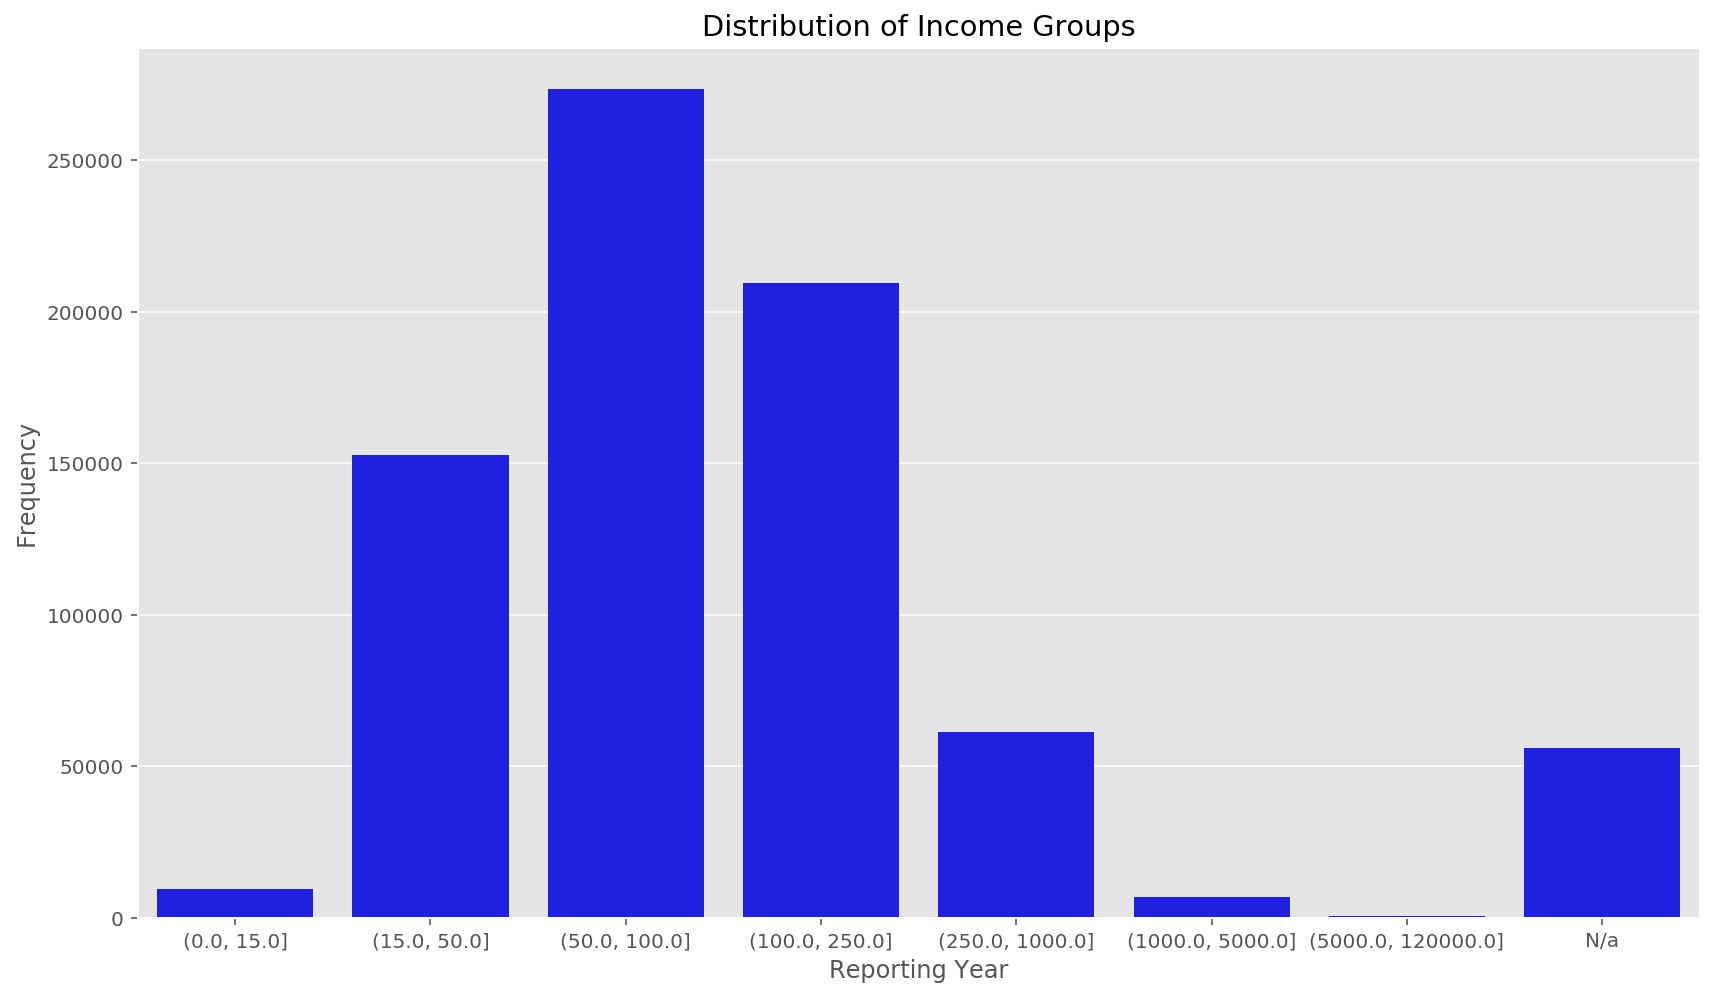

In [67]:
plt.figure(figsize=(14, 8))
ax = sns.countplot(df['binned_income'], color='b',
                   order=['(0.0, 15.0]','(15.0, 50.0]','(50.0, 100.0]','(100.0, 250.0]','(250.0, 1000.0]', 
                          '(1000.0, 5000.0]','(5000.0, 120000.0]','N/a'])

plt.title('Distribution of Income Groups')
ax.set_xlabel('Reporting Year')
ax.set_ylabel('Frequency');

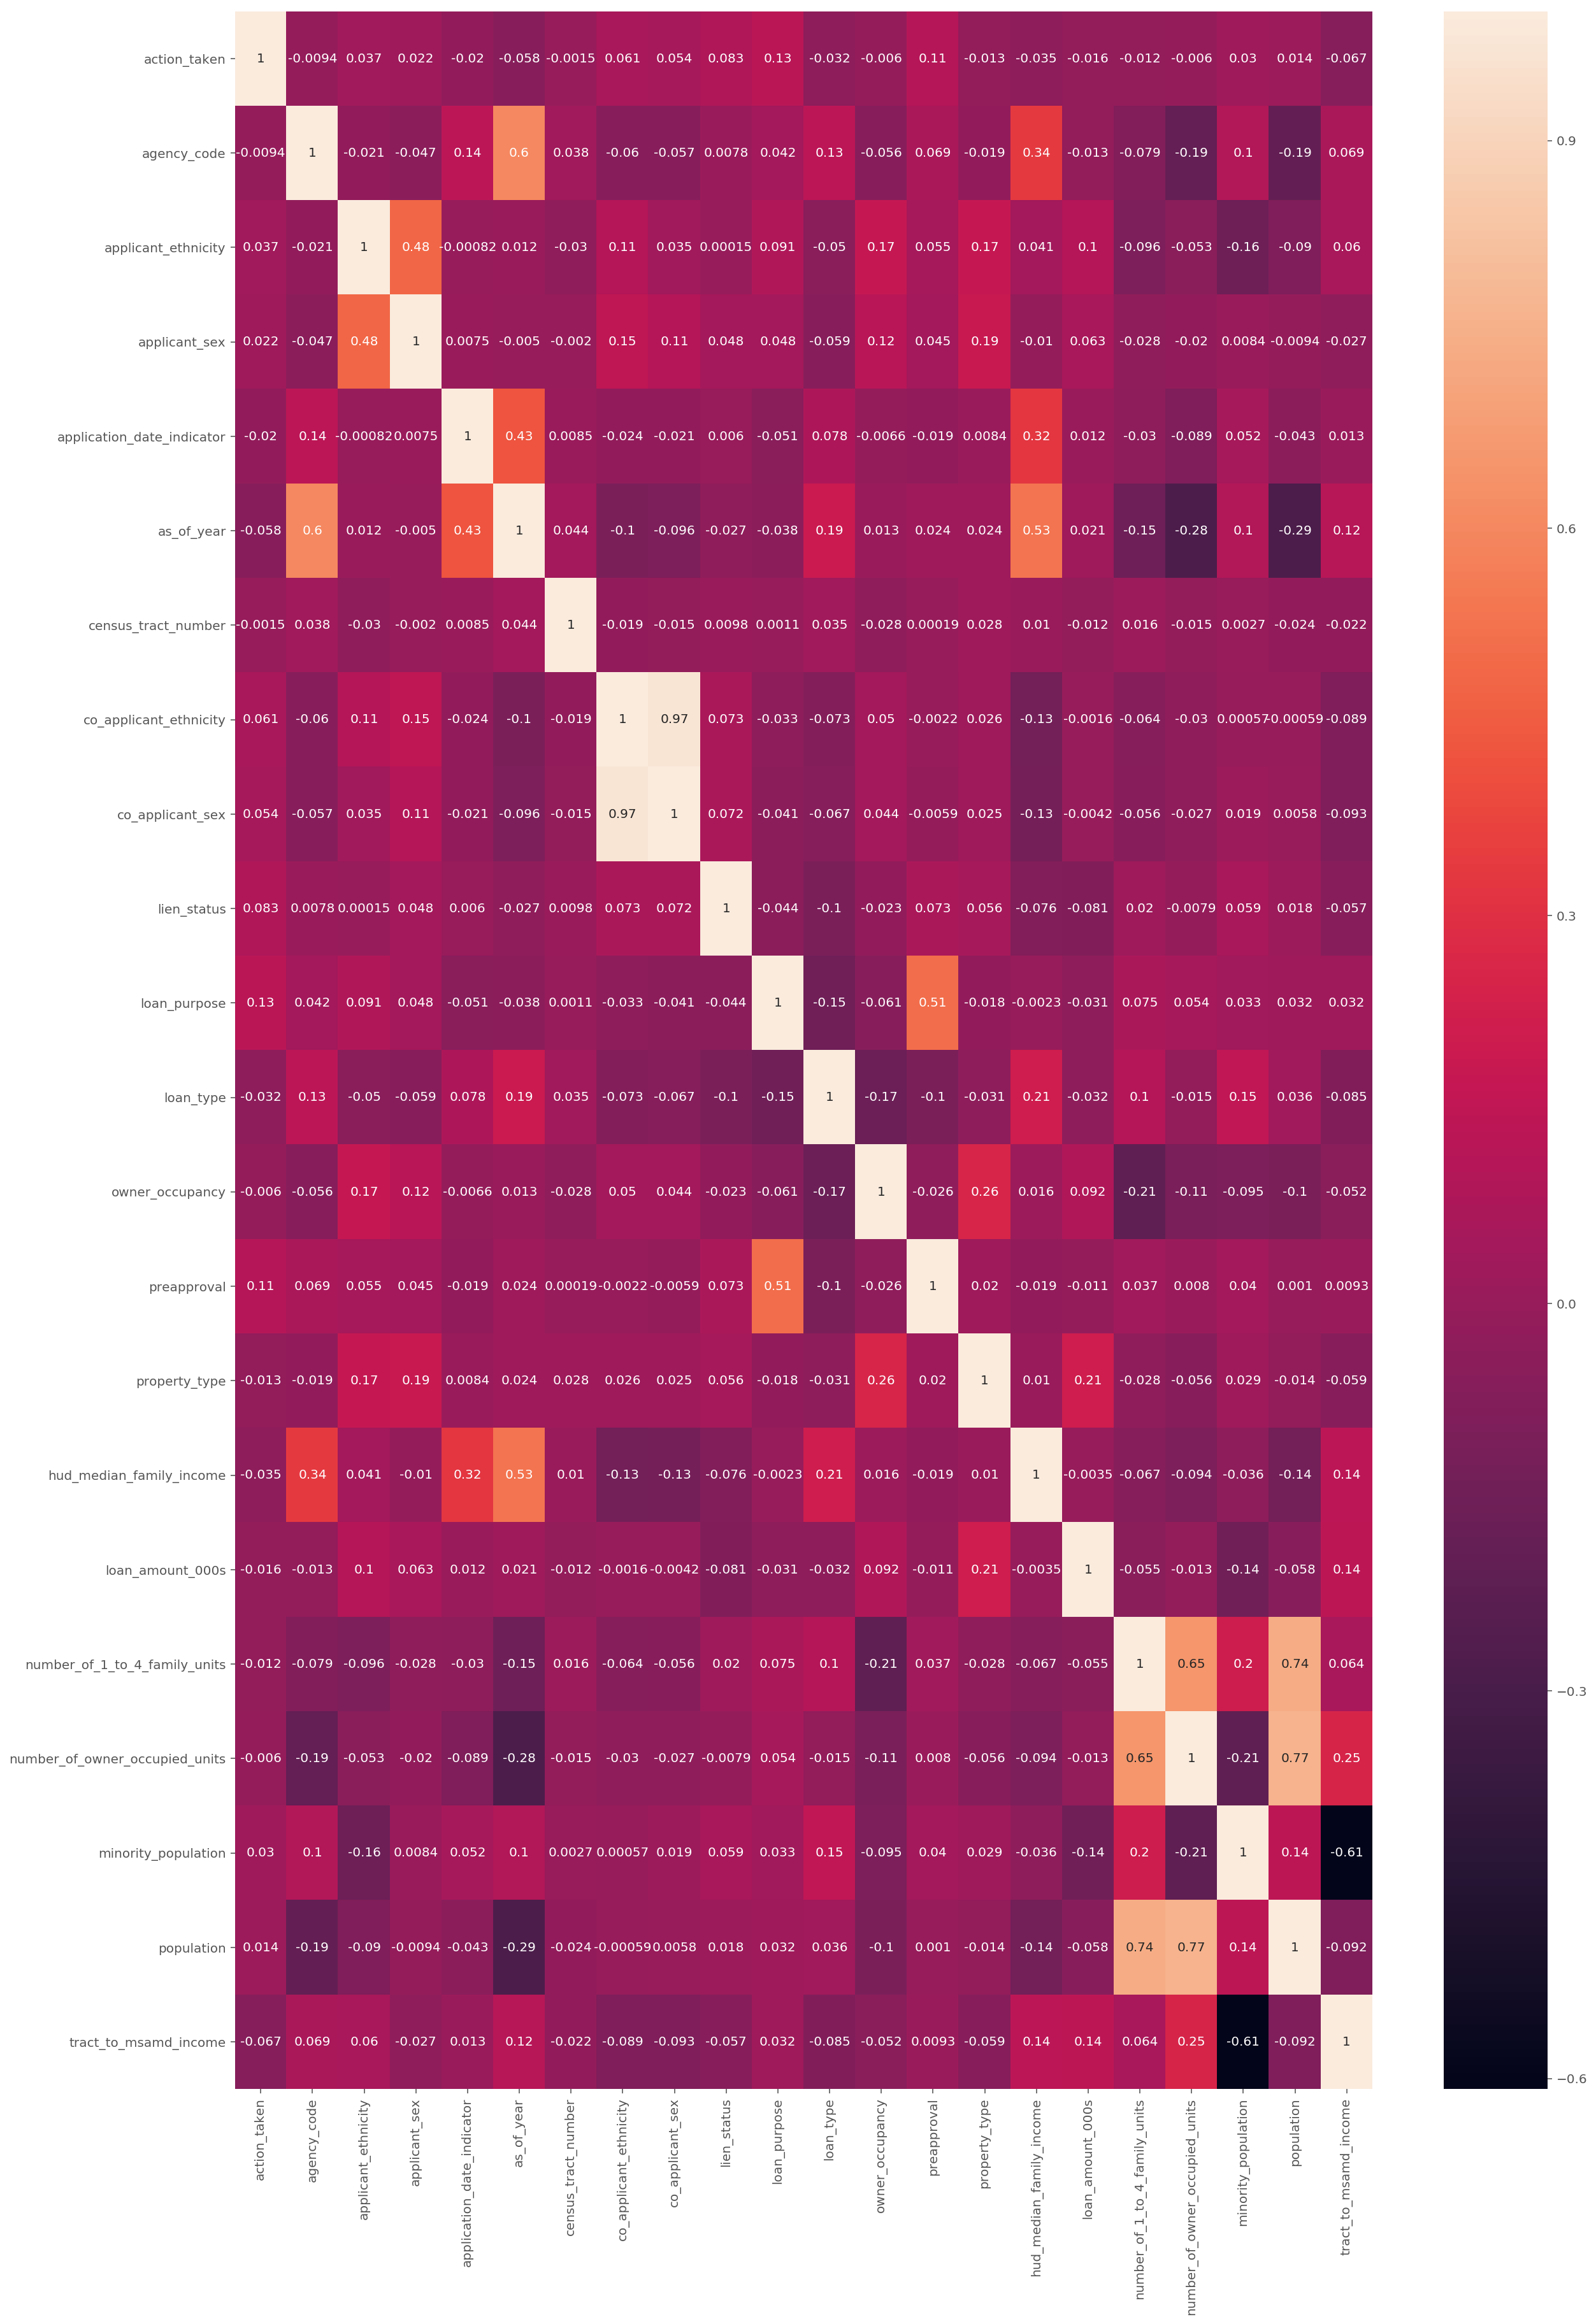

In [68]:
plt.figure(figsize=(20,30))
sns.heatmap(df.drop('target', axis=1).corr(), annot=True);

# Modeling & Results

In [69]:
x_cols = [cols for cols in df.columns if cols not in ['action_taken', 'action_taken_name', 'agency_code', 
                                                      'agency_name','applicant_ethnicity', 'applicant_sex',
                                                     'co_applicant_ethnicity', 'co_applicant_sex', 'lien_status',
                                                     'loan_purpose', 'loan_type','owner_occupancy', 'preapproval',
                                                     'property_type', 'purchaser_type', 'Approved','target',
                                                     'census_tract_number', 'respondent_id']]

In [70]:
def cols_to_dummy_prep(df):
    for i in x_cols:
        if df[i].dtype == 'object' or i in ['application_date_indicator']:
            df[i] = df[i].map((lambda x: i + '_' + str(x).replace('-', '_').replace(' ', '_').replace(',','_').replace('.','_').replace(')','_').replace('(','_').replace(']','_').replace('/','_'))) #add labels to each column for model interpretability
    return df

In [71]:
df[x_cols] = cols_to_dummy_prep(df[x_cols])

/anaconda3/envs/dsi/lib/python3.6/site-packages/ipykernel/__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [72]:
train_set = df[df['as_of_year'].between(2014,2016)].sample(frac=.2, random_state=1)
test_set = df[df['as_of_year'] == 2017].sample(frac=.2, random_state=1)

In [73]:
train_set.shape

(34685, 50)

In [74]:
test_set.shape

(11989, 50)

In [75]:
X_train = train_set[x_cols]
y_train = train_set['target']

X_test = test_set[x_cols]
y_test = test_set['target']

In [76]:
#source can be found here: https://blomadam.github.io/.
class ModelTransformer(BaseEstimator,TransformerMixin):

    def __init__(self, model=None):
        self.model = model

    def fit(self, *args, **kwargs):
        self.model.fit(*args, **kwargs)
        return self

    def transform(self, X, **transform_params):
        return self.model.transform(X)
    
class SampleExtractor(BaseEstimator, TransformerMixin):
    """Takes in varaible names as a **list**"""

    def __init__(self, vars):
        self.vars = vars  # e.g. pass in a column names to extract

    def transform(self, X, y=None):
        if len(self.vars) > 1:
            return pd.DataFrame(X[self.vars]) # where the actual feature extraction happens
        else:
            return pd.Series(X[self.vars[0]])

    def fit(self, X, y=None):
        return self  # generally does nothing
    
    
class DenseTransformer(BaseEstimator,TransformerMixin):

    def transform(self, X, y=None, **fit_params):
        return X.todense()

    def fit_transform(self, X, y=None, **fit_params):
        self.fit(X, y, **fit_params)
        return self.transform(X)

    def fit(self, X, y=None, **fit_params):
        return self

In [77]:
agency = Pipeline([
              ('text',SampleExtractor(['agency_abbr'])),
              ('dummify', CountVectorizer(binary=True)),
              ('densify', DenseTransformer()),
             ])
applicant_ethnicity = Pipeline([
              ('text',SampleExtractor(['applicant_ethnicity_name'])),
              ('dummify', CountVectorizer(binary=True)),
              ('densify', DenseTransformer()),
             ])
applicant_race_name_1 = Pipeline([
              ('text',SampleExtractor(['applicant_race_name_1'])),
              ('dummify', CountVectorizer(binary=True)),
              ('densify', DenseTransformer()),
             ])
applicant_race_name_2 = Pipeline([
              ('text',SampleExtractor(['applicant_race_name_2'])),
              ('dummify', CountVectorizer(binary=True)),
              ('densify', DenseTransformer()),
             ])
applicant_race_name_3 = Pipeline([
              ('text',SampleExtractor(['applicant_race_name_3'])),
              ('dummify', CountVectorizer(binary=True)),
              ('densify', DenseTransformer()),
             ])
applicant_race_name_4 = Pipeline([
              ('text',SampleExtractor(['applicant_race_name_4'])),
              ('dummify', CountVectorizer(binary=True)),
              ('densify', DenseTransformer()),
             ])
applicant_race_name_5 = Pipeline([
              ('text',SampleExtractor(['applicant_race_name_5'])),
              ('dummify', CountVectorizer(binary=True)),
              ('densify', DenseTransformer()),
             ])
applicant_sex_name = Pipeline([
              ('text',SampleExtractor(['applicant_sex_name'])),
              ('dummify', CountVectorizer(binary=True)),
              ('densify', DenseTransformer()),
             ])
application_date_indicator = Pipeline([
              ('text',SampleExtractor(['application_date_indicator'])),
              ('dummify', CountVectorizer(binary=True)),
              ('densify', DenseTransformer()),
             ])
census_tract_number = Pipeline([
              ('text',SampleExtractor(['census_tract_number'])),
              ('dummify', CountVectorizer(binary=True)),
              ('densify', DenseTransformer()),
             ])
co_applicant_ethnicity_name = Pipeline([
              ('text',SampleExtractor(['co_applicant_ethnicity_name'])),
              ('dummify', CountVectorizer(binary=True)),
              ('densify', DenseTransformer()),
             ])
co_applicant_race_name_1 = Pipeline([
              ('text',SampleExtractor(['co_applicant_race_name_1'])),
              ('dummify', CountVectorizer(binary=True)),
              ('densify', DenseTransformer()),
             ])
co_applicant_race_name_2 = Pipeline([
              ('text',SampleExtractor(['co_applicant_race_name_2'])),
              ('dummify', CountVectorizer(binary=True)),
              ('densify', DenseTransformer()),
             ])
co_applicant_race_name_3 = Pipeline([
              ('text',SampleExtractor(['co_applicant_race_name_3'])),
              ('dummify', CountVectorizer(binary=True)),
              ('densify', DenseTransformer()),
             ])
co_applicant_race_name_4 = Pipeline([
              ('text',SampleExtractor(['co_applicant_race_name_4'])),
              ('dummify', CountVectorizer(binary=True)),
              ('densify', DenseTransformer()),
             ])
co_applicant_race_name_5 = Pipeline([
              ('text',SampleExtractor(['co_applicant_race_name_5'])),
              ('dummify', CountVectorizer(binary=True)),
              ('densify', DenseTransformer()),
             ])
co_applicant_sex_name = Pipeline([
              ('text',SampleExtractor(['co_applicant_sex_name'])),
              ('dummify', CountVectorizer(binary=True)),
              ('densify', DenseTransformer()),
             ])
lien_status_name = Pipeline([
              ('text',SampleExtractor(['lien_status_name'])),
              ('dummify', CountVectorizer(binary=True)),
              ('densify', DenseTransformer()),
             ])
loan_purpose_name = Pipeline([
              ('text',SampleExtractor(['loan_purpose_name'])),
              ('dummify', CountVectorizer(binary=True)),
              ('densify', DenseTransformer()),
             ])
loan_type_name = Pipeline([
              ('text',SampleExtractor(['loan_type_name'])),
              ('dummify', CountVectorizer(binary=True)),
              ('densify', DenseTransformer()),
             ])
owner_occupancy_name = Pipeline([
              ('text',SampleExtractor(['owner_occupancy_name'])),
              ('dummify', CountVectorizer(binary=True)),
              ('densify', DenseTransformer()),
             ])
preapproval_name = Pipeline([
              ('text',SampleExtractor(['preapproval_name'])),
              ('dummify', CountVectorizer(binary=True)),
              ('densify', DenseTransformer()),
             ])
property_type_name = Pipeline([
              ('text',SampleExtractor(['property_type_name'])),
              ('dummify', CountVectorizer(binary=True)),
              ('densify', DenseTransformer()),
             ])
respondent_id = Pipeline([
              ('text',SampleExtractor(['respondent_id'])),
              ('dummify', CountVectorizer(binary=True)),
              ('densify', DenseTransformer()),
             ])
binned_rate_spread = Pipeline([
              ('text',SampleExtractor(['binned_rate_spread'])),
              ('dummify', CountVectorizer(binary=True)),
              ('densify', DenseTransformer()),
             ])
binned_income = Pipeline([
              ('text',SampleExtractor(['binned_income'])),
              ('dummify', CountVectorizer(binary=True)),
              ('densify', DenseTransformer()),
             ])

In [78]:
strat_kfolds = StratifiedKFold(n_splits=3,shuffle=True,random_state=1) #stratified kfolds for cross validation
#create list of features that will not be dummied (i.e. continuous features)
cont_col_list = [cols for cols in X_train.columns if X_train[cols].dtype != 'object']

In [93]:
#create pipeline for the SGDClassifier
pipeline_rf = Pipeline([
    ('features', FeatureUnion([
        ('agency', agency),
        ('applicant_ethnicity', applicant_ethnicity),
        ('applicant_race_name_1', applicant_race_name_1),
        ('applicant_race_name_2', applicant_race_name_2),
        ('applicant_race_name_3', applicant_race_name_3),
        ('applicant_race_name_4', applicant_race_name_4),
        ('applicant_race_name_5', applicant_race_name_5),
        ('applicant_sex_name', applicant_sex_name),
        ('application_date_indicator', application_date_indicator),
#         ('census_tract_number', census_tract_number),
        ('co_applicant_ethnicity_name', co_applicant_ethnicity_name),
        ('co_applicant_race_name_1', co_applicant_race_name_1),
        ('co_applicant_race_name_2', co_applicant_race_name_2),
        ('co_applicant_race_name_3', co_applicant_race_name_3),
        ('co_applicant_race_name_4', co_applicant_race_name_4),
        ('co_applicant_race_name_5', co_applicant_race_name_5),
        ('co_applicant_sex_name', co_applicant_sex_name),
        ('lien_status_name',lien_status_name),
        ('loan_purpose_name',loan_purpose_name),
        ('loan_type_name',loan_type_name),
        ('owner_occupancy_name',owner_occupancy_name),
        ('preapproval_name',preapproval_name),
        ('property_type_name',property_type_name),
#         ('respondent_id',respondent_id),
        ('binned_rate_spread',binned_rate_spread),
        ('binned_income',binned_income),
        ('cont_features', Pipeline([
                      ('continuous', SampleExtractor(cont_col_list)),
                      ])),
        ])),
#         ('scale', ModelTransformer()),
        ('rf', RandomForestClassifier(random_state=2)),
])

params_rf = {
#     'scale__model': [StandardScaler(), MinMaxScaler()],
    'rf__n_estimators':[150,200,250],
#     'rf__max_features':['auto', 'sqrt'],
    'rf__min_samples_leaf':[8,9,10],
    'rf__max_depth':[8,9,10]
}
    

gs1 = GridSearchCV(pipeline_rf,param_grid=params_rf, cv=strat_kfolds, verbose=1)
gs1.fit(X_train,y_train)
print('best cv score', gs1.best_score_)
print('best paramas', gs1.best_params_)
print('test score', gs1.score(X_test, y_test))

Fitting 3 folds for each of 27 candidates, totalling 81 fits


[Parallel(n_jobs=1)]: Done  81 out of  81 | elapsed: 12.7min finished


best cv score 0.6791696698861179
best paramas {'rf__max_depth': 10, 'rf__min_samples_leaf': 10, 'rf__n_estimators': 150}
test score 0.6915505880390358


In [94]:
gs1.cv_results_['mean_test_score'].mean()

0.6770457930901927

/anaconda3/envs/dsi/lib/python3.6/site-packages/sklearn/utils/deprecation.py:122: FutureWarning: You are accessing a training score ('mean_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/anaconda3/envs/dsi/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


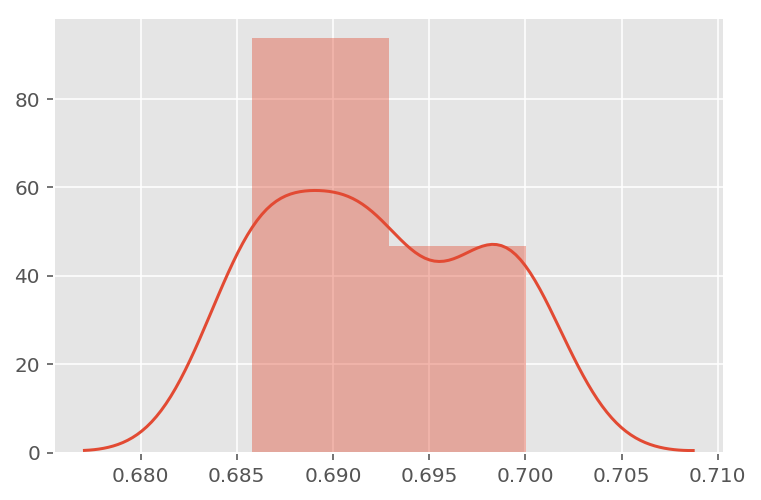

In [95]:
sns.distplot(gs1.cv_results_['mean_train_score'])

In [96]:
gs1.cv_results_['mean_train_score'].mean()

/anaconda3/envs/dsi/lib/python3.6/site-packages/sklearn/utils/deprecation.py:122: FutureWarning: You are accessing a training score ('mean_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)


0.692281378084412

In [97]:
#extract coefficients for each feature and print out the top 50
feature_names = [] #create empty list

feature_cols = [agency, applicant_ethnicity, applicant_race_name_1, applicant_race_name_2, applicant_race_name_3,
                applicant_race_name_4, applicant_race_name_5, applicant_sex_name, application_date_indicator, 
                co_applicant_ethnicity_name, co_applicant_race_name_1, co_applicant_race_name_2, co_applicant_race_name_3,
                co_applicant_race_name_4, co_applicant_race_name_5, co_applicant_sex_name, lien_status_name, loan_purpose_name,
                loan_type_name, owner_occupancy_name, preapproval_name, property_type_name, binned_rate_spread, binned_income]

for i in feature_cols: #iterate through each dummied feature
    feature_names.append(i.fit(X_train).steps[1][1].get_feature_names()) #add feature names to list

columns_list = [i for i in X_train.columns if i in cont_col_list] #create column list of features not dummied

feature_names.append(columns_list) #combine lists of feature names

feature_names = [i for j in feature_names for i in j] #turn list of lists into list of just feature names


In [98]:
rf_model = gs1.best_estimator_
feature_importances = pd.DataFrame(feature_names, rf_model.steps[1][1].feature_importances_.tolist(),columns=['Feature'])
feature_importances.reset_index(inplace=True)
feature_importances.rename({'index':'Feature Importance'}, axis=1, inplace=True)

feature_importances.sort_values(by='Feature Importance', ascending=False)[:50]

,Feature Importance,Feature
67,0.153486,loan_purpose_name_home_purchase
96,0.095767,loan_amount_000s
85,0.091357,binned_rate_spread_n_a
82,0.078422,binned_rate_spread__1_484__5_505_
68,0.068458,loan_purpose_name_refinancing
66,0.043091,loan_purpose_name_home_improvement
64,0.042551,lien_status_name_secured_by_a_first_lien
63,0.037519,lien_status_name_not_secured_by_a_lien
99,0.029582,minority_population
89,0.026804,binned_income__15_0__50_0_


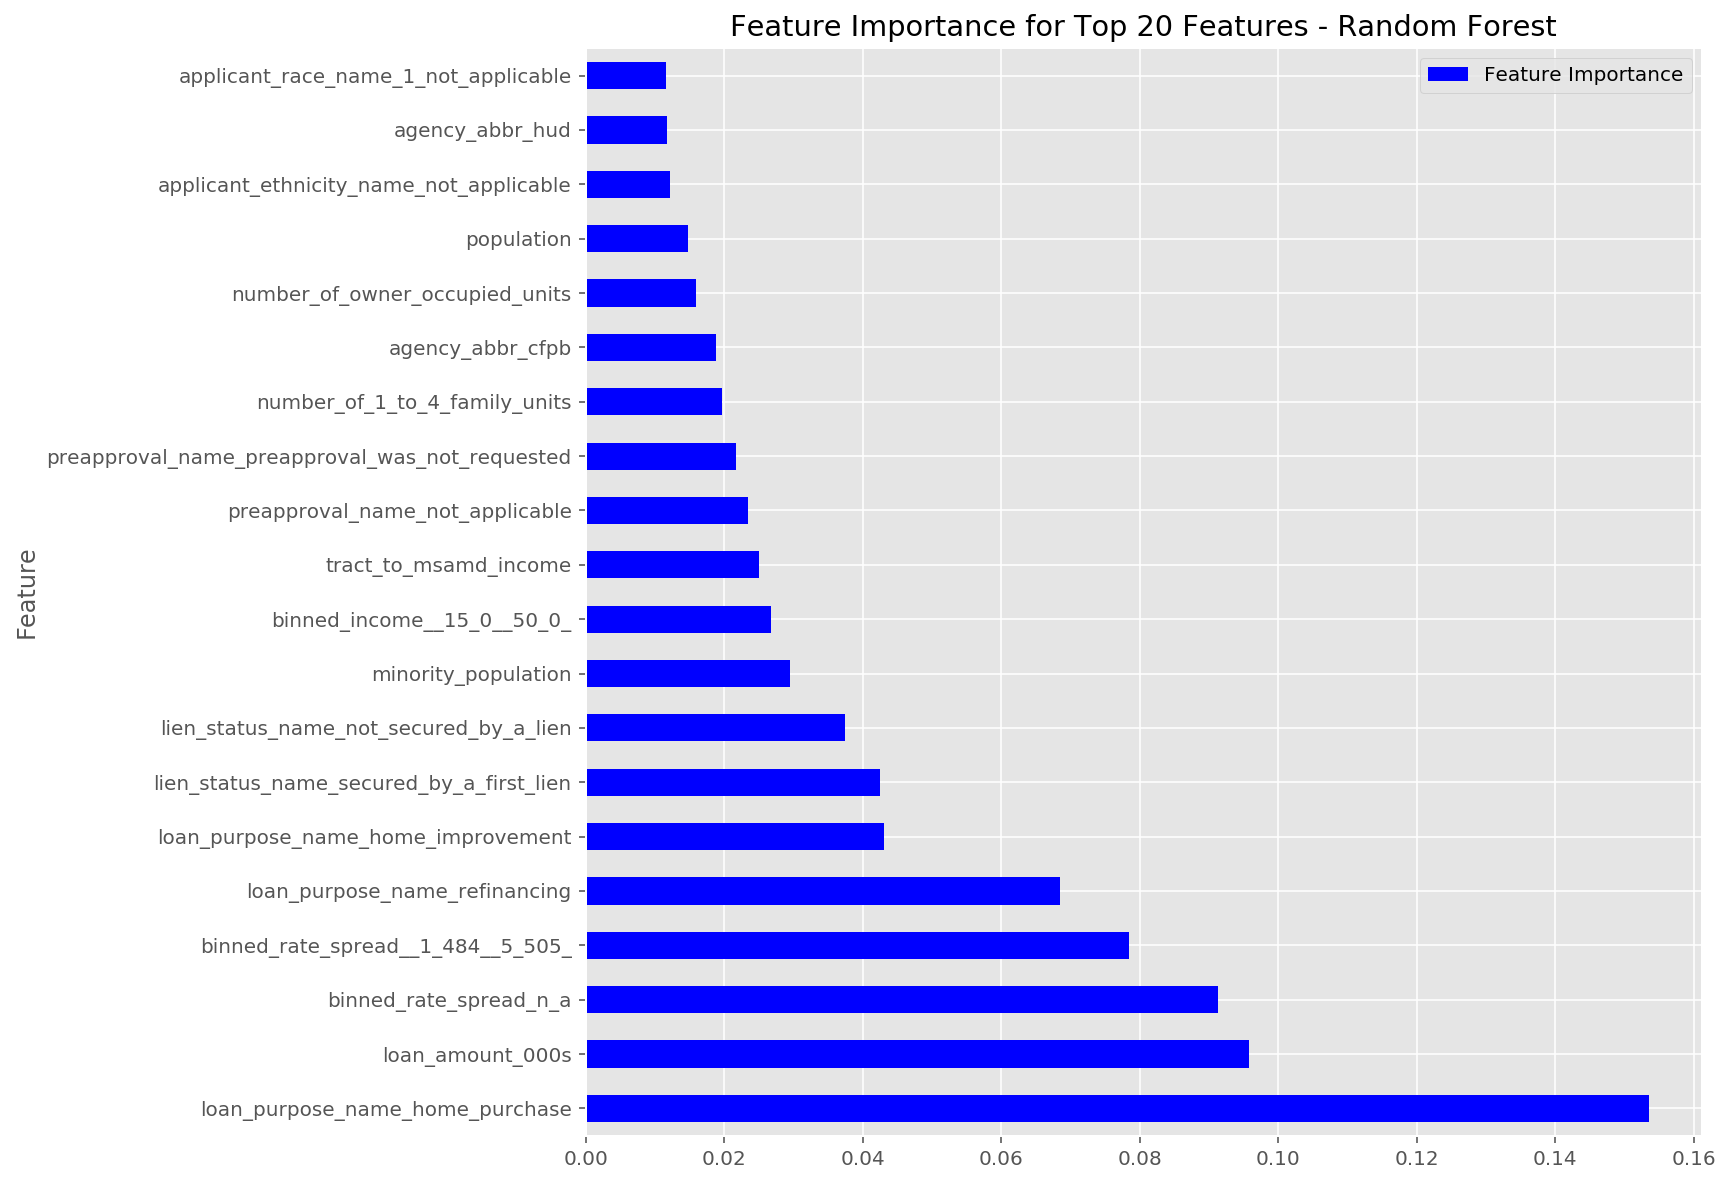

In [99]:
#Plot of top 20 features 
feature_importances.sort_values(by='Feature Importance', ascending=False)[:20].plot(y='Feature Importance',x='Feature',kind='barh', figsize=(10,10), color='b', 
                                  title='Feature Importance for Top 20 Features - Random Forest');

In [100]:
#create pipeline for the SGDClassifier
pipeline_sgd = Pipeline([
    ('features', FeatureUnion([
        ('agency', agency),
        ('applicant_ethnicity', applicant_ethnicity),
        ('applicant_race_name_1', applicant_race_name_1),
        ('applicant_race_name_2', applicant_race_name_2),
        ('applicant_race_name_3', applicant_race_name_3),
        ('applicant_race_name_4', applicant_race_name_4),
        ('applicant_race_name_5', applicant_race_name_5),
        ('applicant_sex_name', applicant_sex_name),
        ('application_date_indicator', application_date_indicator),
#         ('census_tract_number', census_tract_number),
        ('co_applicant_ethnicity_name', co_applicant_ethnicity_name),
        ('co_applicant_race_name_1', co_applicant_race_name_1),
        ('co_applicant_race_name_2', co_applicant_race_name_2),
        ('co_applicant_race_name_3', co_applicant_race_name_3),
        ('co_applicant_race_name_4', co_applicant_race_name_4),
        ('co_applicant_race_name_5', co_applicant_race_name_5),
        ('co_applicant_sex_name', co_applicant_sex_name),
        ('lien_status_name',lien_status_name),
        ('loan_purpose_name',loan_purpose_name),
        ('loan_type_name',loan_type_name),
        ('owner_occupancy_name',owner_occupancy_name),
        ('preapproval_name',preapproval_name),
        ('property_type_name',property_type_name),
#         ('respondent_id',respondent_id),
        ('binned_rate_spread',binned_rate_spread),
        ('binned_income',binned_income),
        ('cont_features', Pipeline([
                      ('continuous', SampleExtractor(cont_col_list)),
                      ])),
        ])),
        ('scale', ModelTransformer()),
        ('sgd', SGDClassifier(loss='log', max_iter=1000, random_state=1)),
])

#create set of parameters to search over for SGDClassifier
params_sgd = {
    'scale__model': [StandardScaler()],
    'sgd__penalty': ['l1', 'l2', 'elasticnet'],
    'sgd__alpha':[.0001, .001, .01],
    'sgd__l1_ratio':[.01,.05,.15],
}
    
#gridsearch over parameters using StratifiedKFold 
gs2 = GridSearchCV(pipeline_sgd,param_grid=params_sgd, cv=strat_kfolds, verbose=1)
gs2.fit(X_train,y_train) #fit gridsearch to training data
print('best cv score', gs2.best_score_) #print best average CV score
print('best paramas', gs2.best_params_) #print parameters from best CV score
print('test score', gs2.score(X_test, y_test)) #score on test set 

Fitting 3 folds for each of 27 candidates, totalling 81 fits


[Parallel(n_jobs=1)]: Done  81 out of  81 | elapsed: 29.3min finished


best cv score 0.6792273316995819
best paramas {'scale__model': StandardScaler(copy=True, with_mean=True, with_std=True), 'sgd__alpha': 0.001, 'sgd__l1_ratio': 0.05, 'sgd__penalty': 'elasticnet'}
test score 0.6943865209775628


In [102]:
sgd_model = gs2.best_estimator_

#create dataframe of coefficients
coef = pd.DataFrame(feature_names, sgd_model.steps[2][1].coef_.tolist(),columns=['Feature']) 
coef.reset_index(inplace=True)

coef.rename({'level_0':'Coefficient'}, axis=1, inplace=True)

#sort coefficients by magnitude 
coef['abs'] = coef['Coefficient'].abs()
coef50 = coef.sort_values(by='abs',ascending=False)[:50]
coef50

,Coefficient,Feature,abs
85,-0.661530,binned_rate_spread_n_a,0.661530
82,0.641568,binned_rate_spread__1_484__5_505_,0.641568
67,0.222773,loan_purpose_name_home_purchase,0.222773
79,-0.181538,property_type_name_manufactured_housing,0.181538
89,-0.160101,binned_income__15_0__50_0_,0.160101
68,-0.149196,loan_purpose_name_refinancing,0.149196
97,0.145879,number_of_1_to_4_family_units,0.145879
86,-0.130707,binned_income__0_0__15_0_,0.130707
64,0.126910,lien_status_name_secured_by_a_first_lien,0.126910
83,0.106141,binned_rate_spread__5_505__9_51_,0.106141


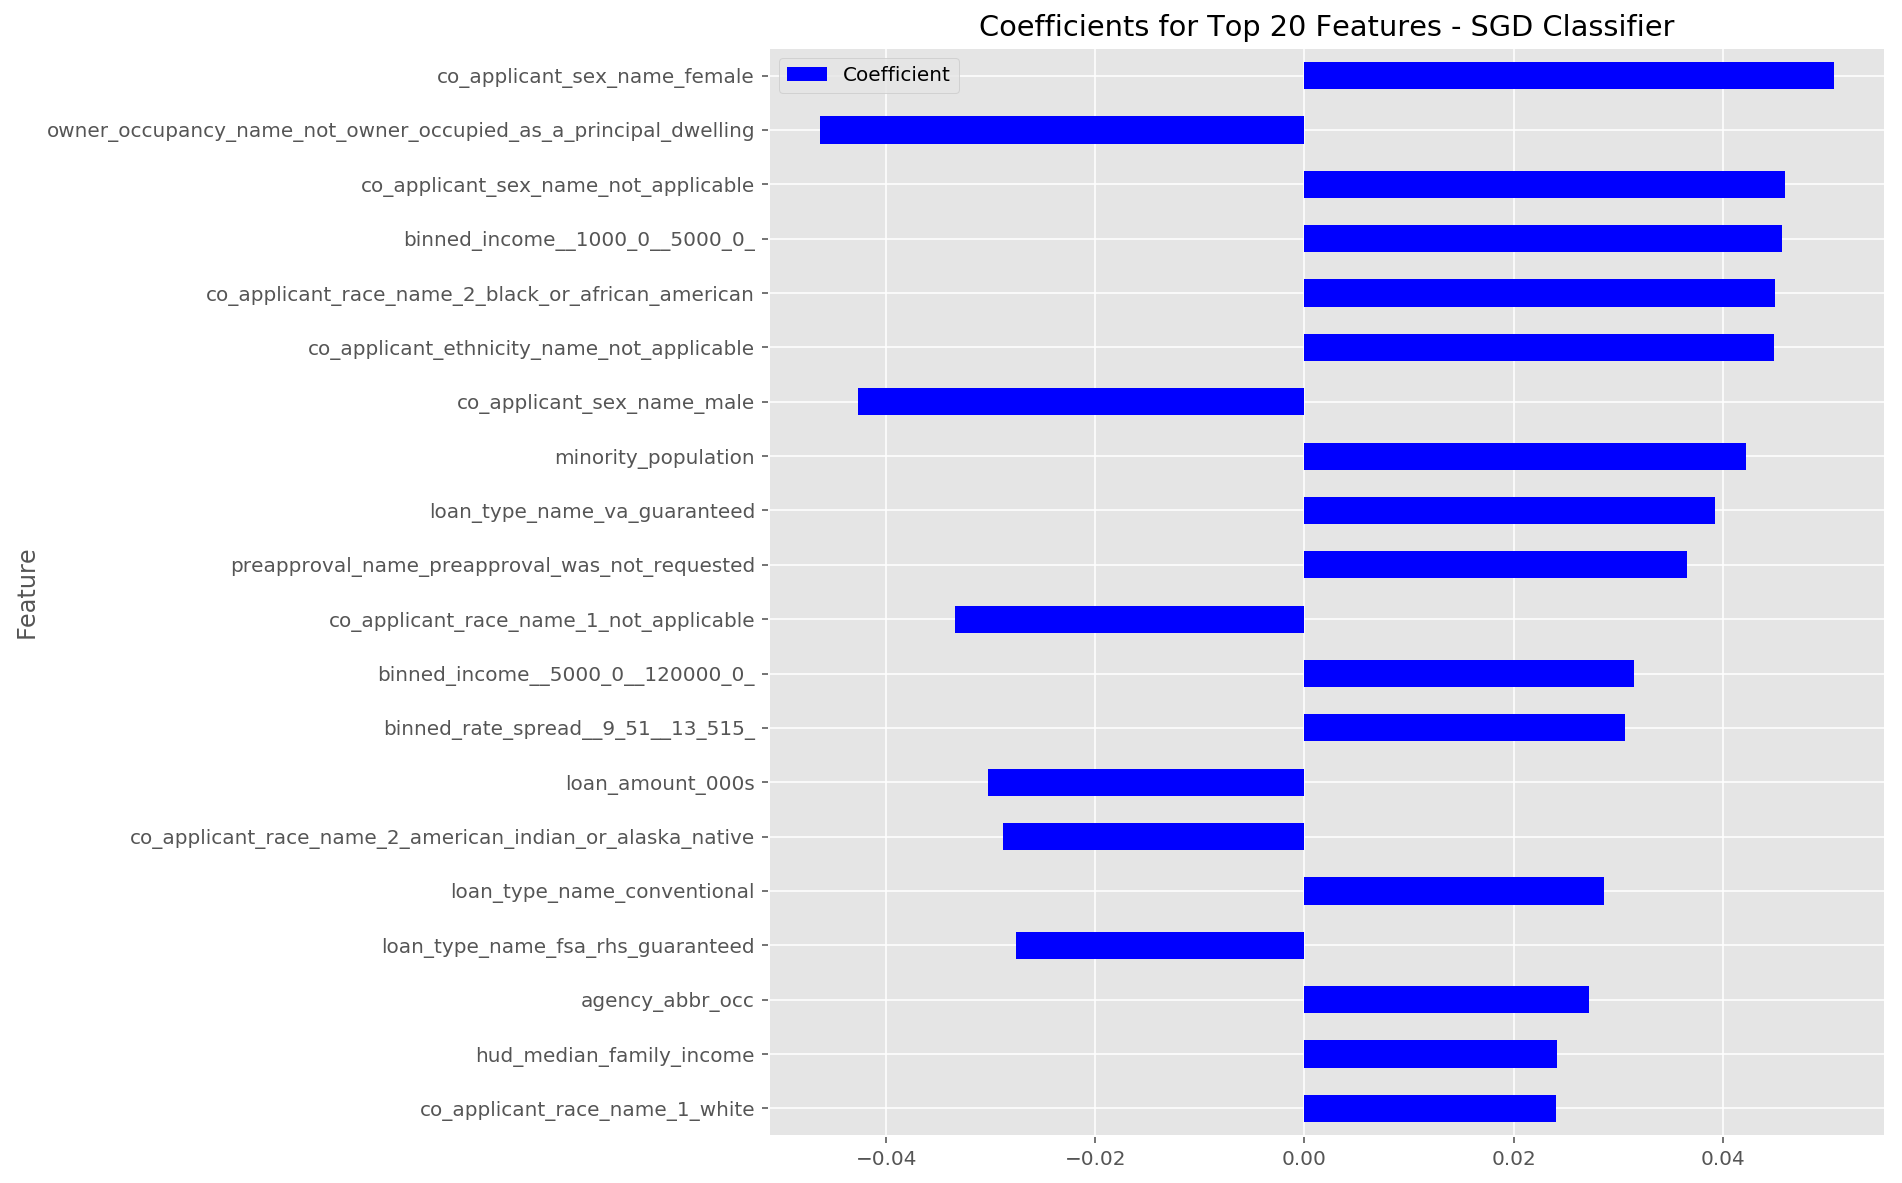

In [103]:
#create plot of coefficients
coef50.sort_values(by='abs')[:20].plot(y='Coefficient',x='Feature',kind='barh', figsize=(10,10), color='b', 
                                  title='Coefficients for Top 20 Features - SGD Classifier');

In [106]:
gs2.cv_results_['mean_test_score'].mean()

0.6776715305474135

In [107]:
gs2.cv_results_['mean_train_score'].mean()

/anaconda3/envs/dsi/lib/python3.6/site-packages/sklearn/utils/deprecation.py:122: FutureWarning: You are accessing a training score ('mean_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)


0.6802252071186339

In [105]:
test_set['target'].value_counts(normalize=True) * 100

1    63.574944
0    36.425056
Name: target, dtype: float64